In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2023/ANESTESIOLOGIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 11 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=200.3, y1=127.3
Page 1, Q1, A: Yellow pixels: 1699
Page 1, Q1, A: Total non-white pixels: 2562
Page 1, Q1, A: Yellow percentage: 66.3%


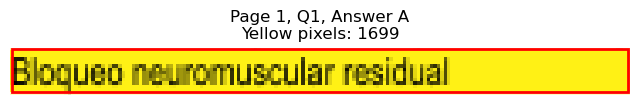

Page 1, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=137.5, y1=139.9
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 458
Page 1, Q1, B: Yellow percentage: 0.0%


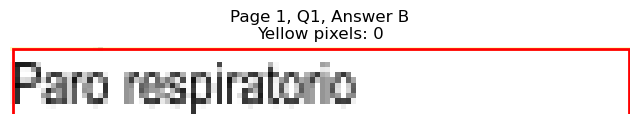

Page 1, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=442.4, y1=127.3
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 567
Page 1, Q1, C: Yellow percentage: 0.0%


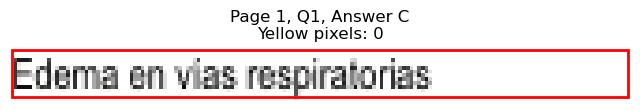

Page 1, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=391.7, y1=139.9
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 305
Page 1, Q1, D: Yellow percentage: 0.0%


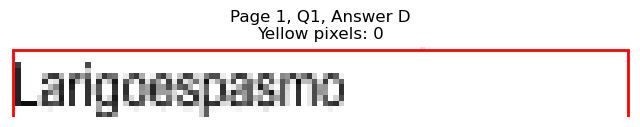


Page 1, Q1 - Selected Answer: A (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=179.2, y1=177.8
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 560
Page 1, Q2, A: Yellow percentage: 0.0%


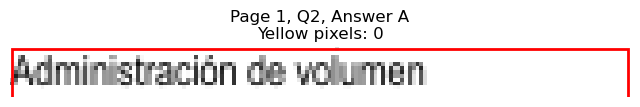

Page 1, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=108.4, y1=190.4
Page 1, Q2, B: Yellow pixels: 0
Page 1, Q2, B: Total non-white pixels: 217
Page 1, Q2, B: Yellow percentage: 0.0%


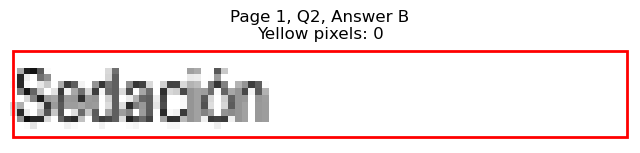

Page 1, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=385.7, y1=177.8
Page 1, Q2, C: Yellow pixels: 1171
Page 1, Q2, C: Total non-white pixels: 1417
Page 1, Q2, C: Yellow percentage: 82.6%


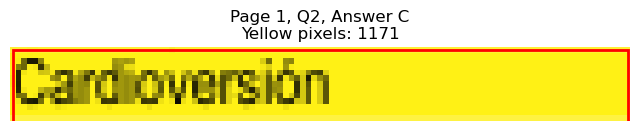

Page 1, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=400.8, y1=190.4
Page 1, Q2, D: Yellow pixels: 124
Page 1, Q2, D: Total non-white pixels: 514
Page 1, Q2, D: Yellow percentage: 24.1%


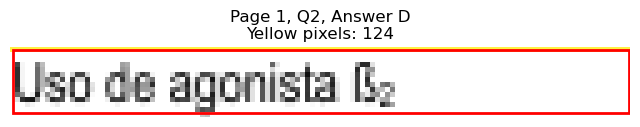


Page 1, Q2 - Selected Answer: C (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=215.7, x1=198.3, y1=228.3
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 626
Page 1, Q3, A: Yellow percentage: 0.0%


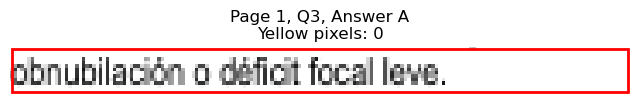

Page 1, Q3 - B: Detected box: x0=68.3, y0=228.3, x1=162.1, y1=240.9
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 433
Page 1, Q3, B: Yellow percentage: 0.0%


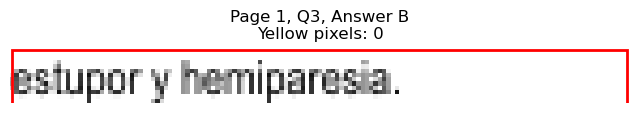

Page 1, Q3 - C: Detected box: x0=327.5, y0=215.7, x1=471.1, y1=228.3
Page 1, Q3, C: Yellow pixels: 195
Page 1, Q3, C: Total non-white pixels: 898
Page 1, Q3, C: Yellow percentage: 21.7%


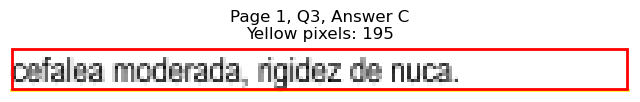

Page 1, Q3 - D: Detected box: x0=327.5, y0=228.3, x1=484.5, y1=240.9
Page 1, Q3, D: Yellow pixels: 2124
Page 1, Q3, D: Total non-white pixels: 2704
Page 1, Q3, D: Yellow percentage: 78.6%


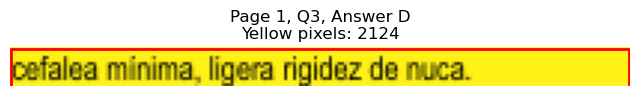


Page 1, Q3 - Selected Answer: D (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=266.1, x1=154.1, y1=278.7
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 449
Page 1, Q4, A: Yellow percentage: 0.0%


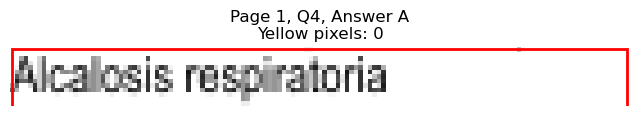

Page 1, Q4 - B: Detected box: x0=68.3, y0=278.8, x1=221.3, y1=291.5
Page 1, Q4, B: Yellow pixels: 2038
Page 1, Q4, B: Total non-white pixels: 2856
Page 1, Q4, B: Yellow percentage: 71.4%


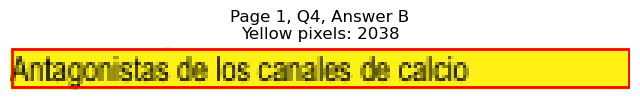

Page 1, Q4 - C: Detected box: x0=327.5, y0=266.1, x1=376.6, y1=278.7
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 265
Page 1, Q4, C: Yellow percentage: 0.0%


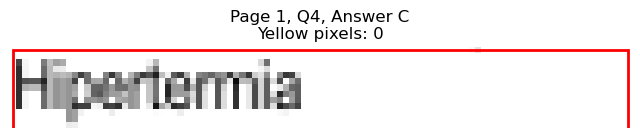

Page 1, Q4 - D: Detected box: x0=327.5, y0=278.8, x1=458.3, y1=291.5
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 658
Page 1, Q4, D: Yellow percentage: 0.0%


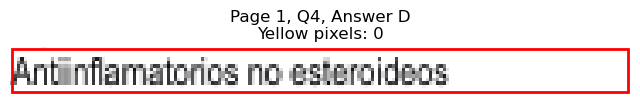


Page 1, Q4 - Selected Answer: B (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=329.2, x1=139.6, y1=341.9
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 374
Page 1, Q5, A: Yellow percentage: 0.0%


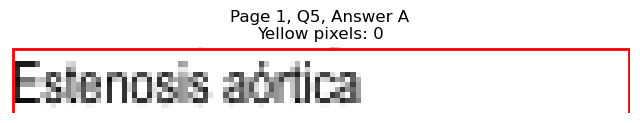

Page 1, Q5 - B: Detected box: x0=68.3, y0=341.9, x1=150.0, y1=354.6
Page 1, Q5, B: Yellow pixels: 1427
Page 1, Q5, B: Total non-white pixels: 1862
Page 1, Q5, B: Yellow percentage: 76.6%


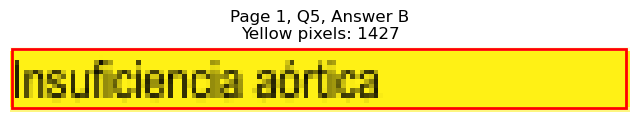

Page 1, Q5 - C: Detected box: x0=327.5, y0=329.2, x1=436.4, y1=341.9
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 594
Page 1, Q5, C: Yellow percentage: 0.0%


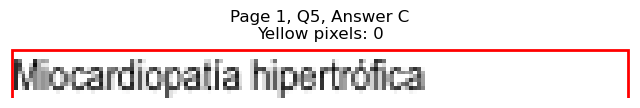

Page 1, Q5 - D: Detected box: x0=327.5, y0=341.9, x1=509.7, y1=354.6
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 976
Page 1, Q5, D: Yellow percentage: 0.0%


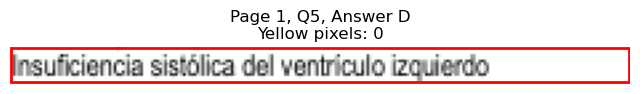


Page 1, Q5 - Selected Answer: B (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=404.9, x1=231.9, y1=417.6
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 846
Page 1, Q6, A: Yellow percentage: 0.0%


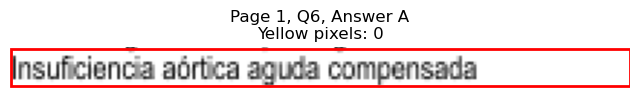

Page 1, Q6 - B: Detected box: x0=68.3, y0=417.6, x1=225.3, y1=430.3
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 813
Page 1, Q6, B: Yellow percentage: 0.0%


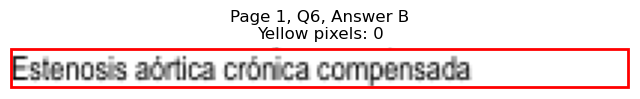

Page 1, Q6 - C: Detected box: x0=327.5, y0=404.9, x1=490.1, y1=417.6
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 842
Page 1, Q6, C: Yellow percentage: 0.0%


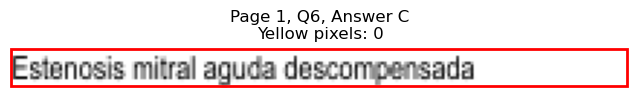

Page 1, Q6 - D: Detected box: x0=327.5, y0=417.6, x1=504.6, y1=430.3
Page 1, Q6, D: Yellow pixels: 1861
Page 1, Q6, D: Total non-white pixels: 2996
Page 1, Q6, D: Yellow percentage: 62.1%


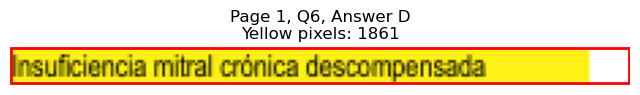


Page 1, Q6 - Selected Answer: D (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=468.1, x1=142.6, y1=480.7
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 361
Page 1, Q7, A: Yellow percentage: 0.0%


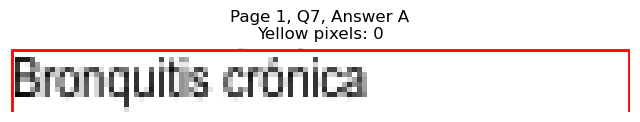

Page 1, Q7 - B: Detected box: x0=68.3, y0=480.8, x1=112.5, y1=493.4
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 221
Page 1, Q7, B: Yellow percentage: 0.0%


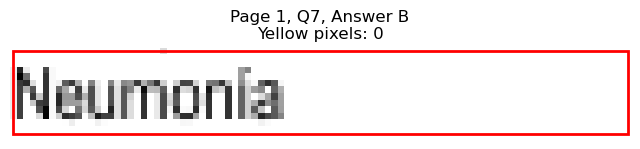

Page 1, Q7 - C: Detected box: x0=327.5, y0=468.1, x1=353.1, y1=480.7
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 120
Page 1, Q7, C: Yellow percentage: 0.0%


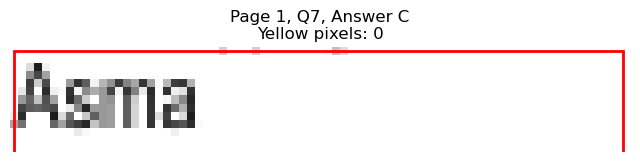

Page 1, Q7 - D: Detected box: x0=327.5, y0=480.8, x1=367.7, y1=493.4
Page 1, Q7, D: Yellow pixels: 938
Page 1, Q7, D: Total non-white pixels: 1274
Page 1, Q7, D: Yellow percentage: 73.6%


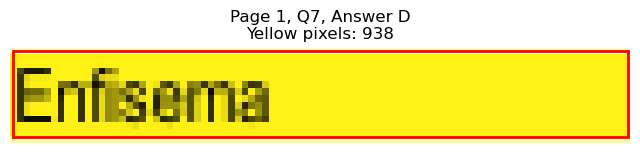


Page 1, Q7 - Selected Answer: D (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=531.2, x1=120.5, y1=543.8
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 277
Page 1, Q8, A: Yellow percentage: 0.0%


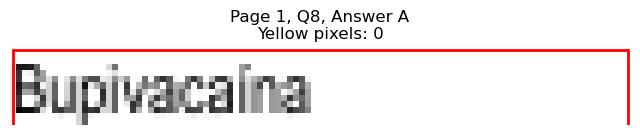

Page 1, Q8 - B: Detected box: x0=68.3, y0=543.8, x1=168.1, y1=556.4
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 475
Page 1, Q8, B: Yellow percentage: 0.0%


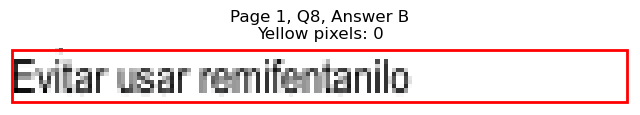

Page 1, Q8 - C: Detected box: x0=327.5, y0=531.2, x1=413.8, y1=543.8
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 592
Page 1, Q8, C: Yellow percentage: 0.0%


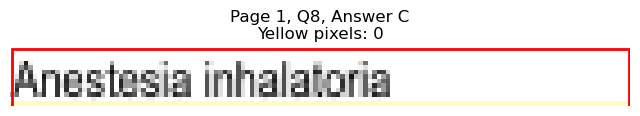

Page 1, Q8 - D: Detected box: x0=327.5, y0=543.8, x1=402.8, y1=556.4
Page 1, Q8, D: Yellow pixels: 1343
Page 1, Q8, D: Total non-white pixels: 1764
Page 1, Q8, D: Yellow percentage: 76.1%


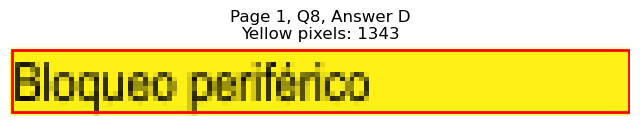


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=594.3, x1=257.0, y1=607.0
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 1151
Page 1, Q9, A: Yellow percentage: 0.0%


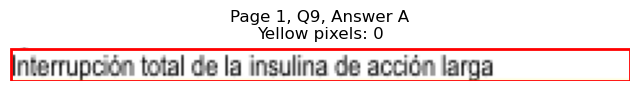

Page 1, Q9 - B: Detected box: x0=68.3, y0=606.9, x1=322.6, y1=619.6
Page 1, Q9, B: Yellow pixels: 2963
Page 1, Q9, B: Total non-white pixels: 4270
Page 1, Q9, B: Yellow percentage: 69.4%


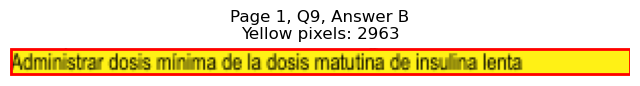

Page 1, Q9 - C: Detected box: x0=68.8, y0=619.6, x1=225.3, y1=632.3
Page 1, Q9, C: Yellow pixels: 208
Page 1, Q9, C: Total non-white pixels: 970
Page 1, Q9, C: Yellow percentage: 21.4%


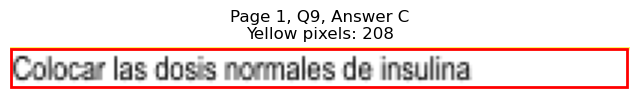

Page 1, Q9 - D: Detected box: x0=68.8, y0=632.2, x1=197.7, y1=644.9
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 658
Page 1, Q9, D: Yellow percentage: 0.0%


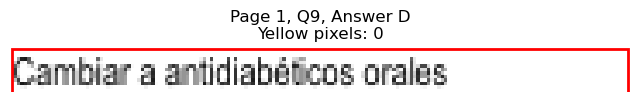


Page 1, Q9 - Selected Answer: B (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=68.3, y0=531.2, x1=120.5, y1=543.8
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 277
Page 1, Q10, A: Yellow percentage: 0.0%


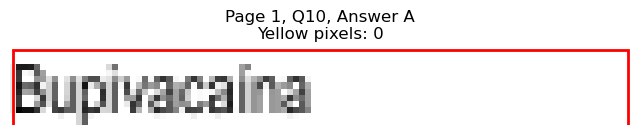

Page 1, Q10 - B: Detected box: x0=68.3, y0=682.7, x1=121.1, y1=695.3
Page 1, Q10, B: Yellow pixels: 104
Page 1, Q10, B: Total non-white pixels: 370
Page 1, Q10, B: Yellow percentage: 28.1%


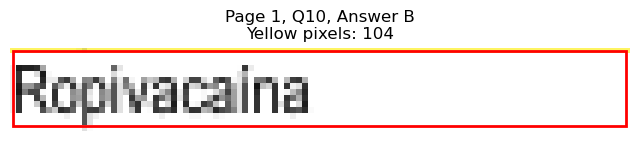

Page 1, Q10 - C: Detected box: x0=327.5, y0=670.1, x1=369.2, y1=682.7
Page 1, Q10, C: Yellow pixels: 0
Page 1, Q10, C: Total non-white pixels: 179
Page 1, Q10, C: Yellow percentage: 0.0%


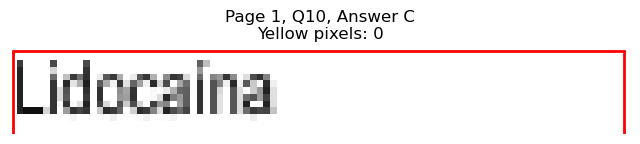

Page 1, Q10 - D: Detected box: x0=327.5, y0=682.7, x1=373.1, y1=695.3
Page 1, Q10, D: Yellow pixels: 0
Page 1, Q10, D: Total non-white pixels: 216
Page 1, Q10, D: Yellow percentage: 0.0%


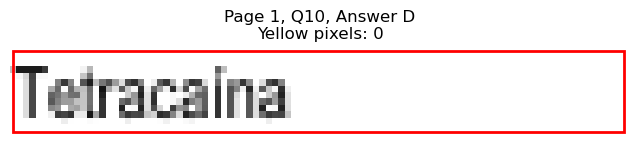


Page 1, Q10 - Selected Answer: B (based on yellow pixel count)




Page 1, Q11 - A: Detected box: x0=68.3, y0=745.9, x1=196.2, y1=758.6
Page 1, Q11, A: Yellow pixels: 0
Page 1, Q11, A: Total non-white pixels: 635
Page 1, Q11, A: Yellow percentage: 0.0%


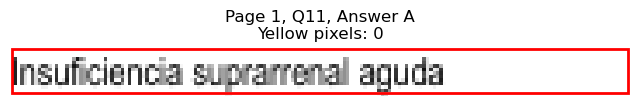

Page 1, Q11 - B: Detected box: x0=68.3, y0=758.5, x1=132.6, y1=771.2
Page 1, Q11, B: Yellow pixels: 0
Page 1, Q11, B: Total non-white pixels: 320
Page 1, Q11, B: Yellow percentage: 0.0%


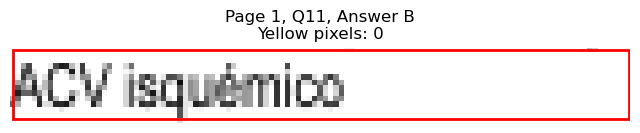

Page 1, Q11 - C: Detected box: x0=327.5, y0=745.9, x1=425.8, y1=758.6
Page 1, Q11, C: Yellow pixels: 149
Page 1, Q11, C: Total non-white pixels: 681
Page 1, Q11, C: Yellow percentage: 21.9%


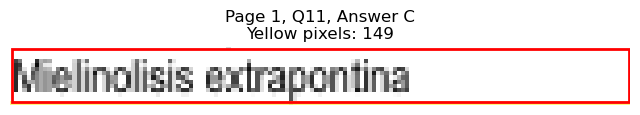

Page 1, Q11 - D: Detected box: x0=327.5, y0=758.5, x1=535.2, y1=771.2
Page 1, Q11, D: Yellow pixels: 1941
Page 1, Q11, D: Total non-white pixels: 2995
Page 1, Q11, D: Yellow percentage: 64.8%


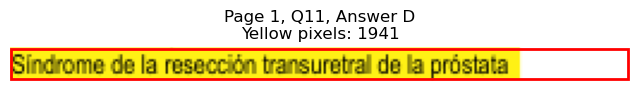


Page 1, Q11 - Selected Answer: D (based on yellow pixel count)





Page 2: Found 11 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=171.6, y1=102.1
Page 2, Q1, A: Yellow pixels: 154
Page 2, Q1, A: Total non-white pixels: 674
Page 2, Q1, A: Yellow percentage: 22.8%


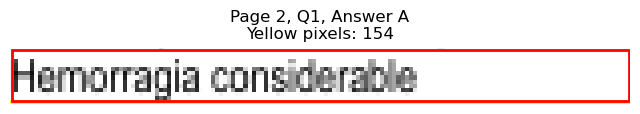

Page 2, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=159.6, y1=114.7
Page 2, Q1, B: Yellow pixels: 1487
Page 2, Q1, B: Total non-white pixels: 1846
Page 2, Q1, B: Yellow percentage: 80.6%


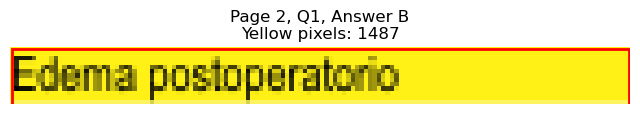

Page 2, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=471.1, y1=102.1
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 713
Page 2, Q1, C: Yellow percentage: 0.0%


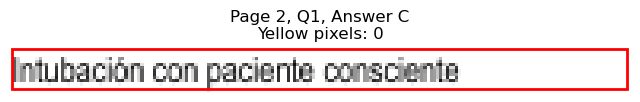

Page 2, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=476.6, y1=114.7
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 756
Page 2, Q1, D: Yellow percentage: 0.0%


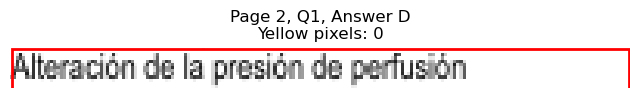


Page 2, Q1 - Selected Answer: B (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=152.5, x1=143.5, y1=165.2
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 394
Page 2, Q2, A: Yellow percentage: 0.0%


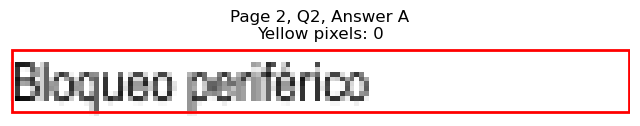

Page 2, Q2 - B: Detected box: x0=68.3, y0=165.1, x1=137.5, y1=177.8
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 299
Page 2, Q2, B: Yellow percentage: 0.0%


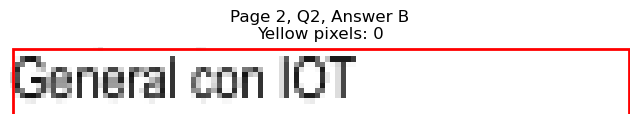

Page 2, Q2 - C: Detected box: x0=327.5, y0=152.5, x1=365.7, y1=165.2
Page 2, Q2, C: Yellow pixels: 988
Page 2, Q2, C: Total non-white pixels: 1246
Page 2, Q2, C: Yellow percentage: 79.3%


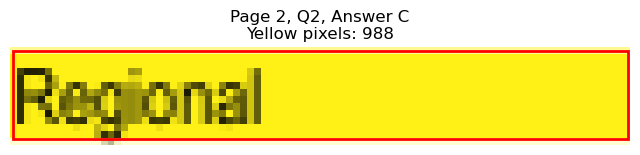

Page 2, Q2 - D: Detected box: x0=327.5, y0=165.1, x1=451.4, y1=177.8
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 798
Page 2, Q2, D: Yellow percentage: 0.0%


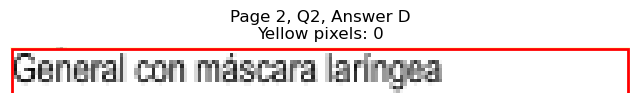


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=151.6, y1=240.9
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 443
Page 2, Q3, A: Yellow percentage: 0.0%


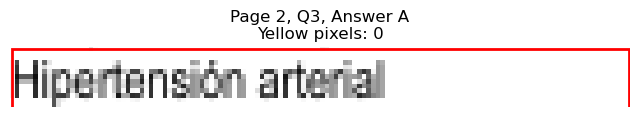

Page 2, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=167.5, y1=253.5
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 490
Page 2, Q3, B: Yellow percentage: 0.0%


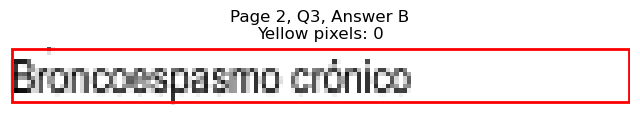

Page 2, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=396.8, y1=240.9
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 469
Page 2, Q3, C: Yellow percentage: 0.0%


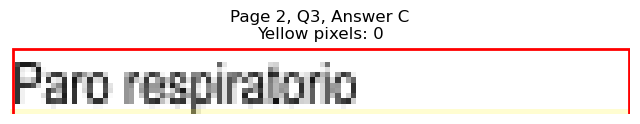

Page 2, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=416.3, y1=253.5
Page 2, Q3, D: Yellow pixels: 1457
Page 2, Q3, D: Total non-white pixels: 1960
Page 2, Q3, D: Yellow percentage: 74.3%


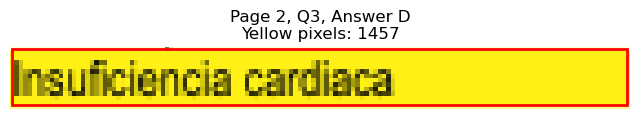


Page 2, Q3 - Selected Answer: D (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=278.8, x1=114.4, y1=291.5
Page 2, Q4, A: Yellow pixels: 97
Page 2, Q4, A: Total non-white pixels: 346
Page 2, Q4, A: Yellow percentage: 28.0%


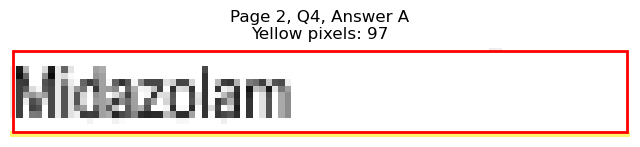

Page 2, Q4 - B: Detected box: x0=68.3, y0=291.4, x1=107.9, y1=304.1
Page 2, Q4, B: Yellow pixels: 1005
Page 2, Q4, B: Total non-white pixels: 1260
Page 2, Q4, B: Yellow percentage: 79.8%


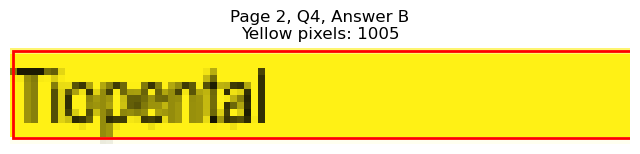

Page 2, Q4 - C: Detected box: x0=327.5, y0=278.8, x1=367.1, y1=291.5
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 200
Page 2, Q4, C: Yellow percentage: 0.0%


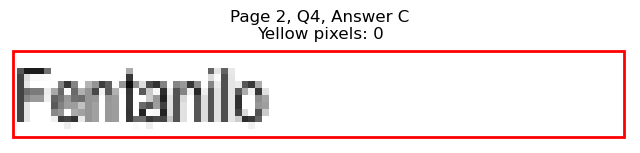

Page 2, Q4 - D: Detected box: x0=327.5, y0=291.4, x1=371.7, y1=304.1
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 237
Page 2, Q4, D: Yellow percentage: 0.0%


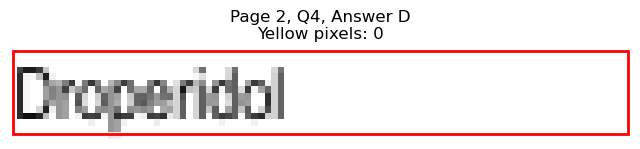


Page 2, Q4 - Selected Answer: B (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=329.2, x1=227.8, y1=341.9
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 777
Page 2, Q5, A: Yellow percentage: 0.0%


Page 2, Q5 - B: Detected box: x0=68.3, y0=341.9, x1=186.1, y1=354.6
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 607
Page 2, Q5, B: Yellow percentage: 0.0%


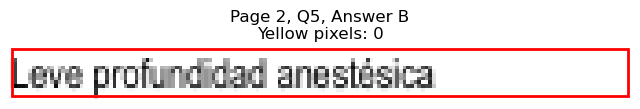

Page 2, Q5 - C: Detected box: x0=327.5, y0=329.2, x1=459.9, y1=341.9
Page 2, Q5, C: Yellow pixels: 1881
Page 2, Q5, C: Total non-white pixels: 2379
Page 2, Q5, C: Yellow percentage: 79.1%


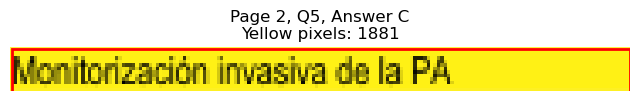

Page 2, Q5 - D: Detected box: x0=327.5, y0=341.9, x1=515.9, y1=354.6
Page 2, Q5, D: Yellow pixels: 213
Page 2, Q5, D: Total non-white pixels: 1128
Page 2, Q5, D: Yellow percentage: 18.9%



Page 2, Q5 - Selected Answer: C (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=379.7, x1=76.8, y1=392.4
Page 2, Q6, A: Yellow pixels: 59
Page 2, Q6, A: Total non-white pixels: 95
Page 2, Q6, A: Yellow percentage: 62.1%


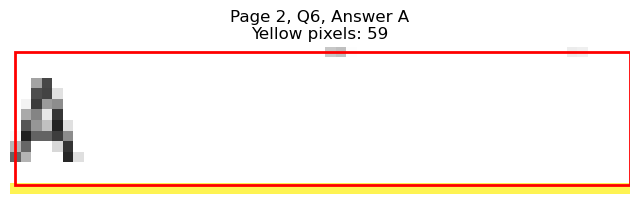

Page 2, Q6 - B: Detected box: x0=68.3, y0=392.3, x1=77.3, y1=405.0
Page 2, Q6, B: Yellow pixels: 757
Page 2, Q6, B: Total non-white pixels: 780
Page 2, Q6, B: Yellow percentage: 97.1%


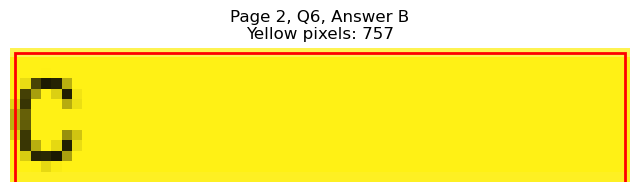

Page 2, Q6 - C: Detected box: x0=315.4, y0=379.7, x1=324.4, y1=392.4
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 66
Page 2, Q6, C: Yellow percentage: 0.0%


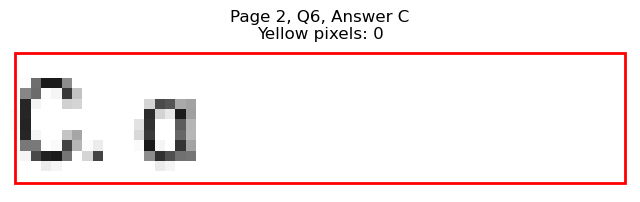

Page 2, Q6 - D: Detected box: x0=315.4, y0=392.3, x1=324.4, y1=405.0
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 72
Page 2, Q6, D: Yellow percentage: 0.0%


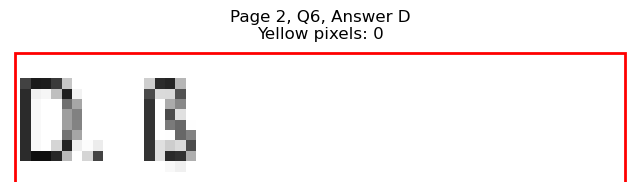


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=468.1, x1=178.1, y1=480.7
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 529
Page 2, Q7, A: Yellow percentage: 0.0%


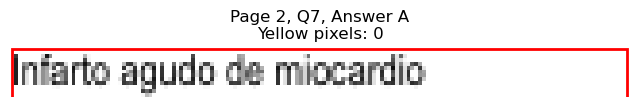

Page 2, Q7 - B: Detected box: x0=68.3, y0=480.8, x1=218.3, y1=493.4
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 757
Page 2, Q7, B: Yellow percentage: 0.0%


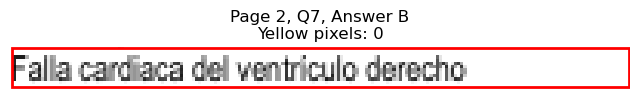

Page 2, Q7 - C: Detected box: x0=327.5, y0=468.1, x1=444.9, y1=480.7
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 574
Page 2, Q7, C: Yellow percentage: 0.0%


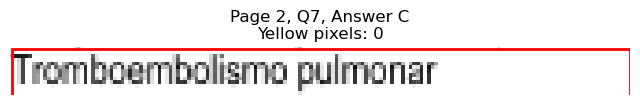

Page 2, Q7 - D: Detected box: x0=327.5, y0=480.8, x1=424.5, y1=493.4
Page 2, Q7, D: Yellow pixels: 1428
Page 2, Q7, D: Total non-white pixels: 2072
Page 2, Q7, D: Yellow percentage: 68.9%



Page 2, Q7 - Selected Answer: D (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=531.2, x1=179.7, y1=543.8
Page 2, Q8, A: Yellow pixels: 1647
Page 2, Q8, A: Total non-white pixels: 2106
Page 2, Q8, A: Yellow percentage: 78.2%


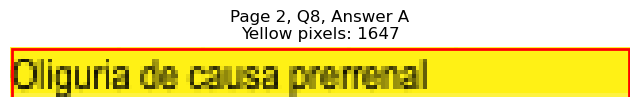

Page 2, Q8 - B: Detected box: x0=68.3, y0=543.8, x1=163.6, y1=556.4
Page 2, Q8, B: Yellow pixels: 140
Page 2, Q8, B: Total non-white pixels: 624
Page 2, Q8, B: Yellow percentage: 22.4%


Page 2, Q8 - C: Detected box: x0=327.5, y0=531.2, x1=446.9, y1=543.8
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 605
Page 2, Q8, C: Yellow percentage: 0.0%


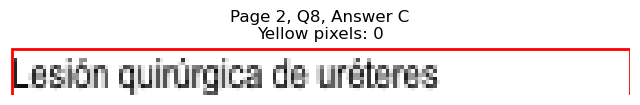

Page 2, Q8 - D: Detected box: x0=327.5, y0=543.8, x1=369.3, y1=556.4
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 228
Page 2, Q8, D: Yellow percentage: 0.0%



Page 2, Q8 - Selected Answer: A (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=581.7, x1=93.9, y1=594.4
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 125
Page 2, Q9, A: Yellow percentage: 0.0%


Page 2, Q9 - B: Detected box: x0=68.3, y0=594.3, x1=93.9, y1=607.0
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 133
Page 2, Q9, B: Yellow percentage: 0.0%


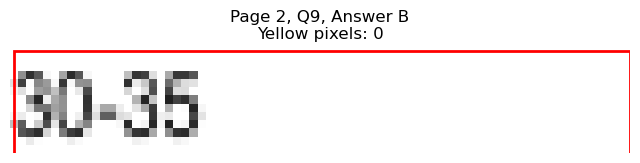

Page 2, Q9 - C: Detected box: x0=327.5, y0=581.7, x1=353.1, y1=594.4
Page 2, Q9, C: Yellow pixels: 77
Page 2, Q9, C: Total non-white pixels: 212
Page 2, Q9, C: Yellow percentage: 36.3%


Page 2, Q9 - D: Detected box: x0=327.5, y0=594.3, x1=353.1, y1=607.0
Page 2, Q9, D: Yellow pixels: 903
Page 2, Q9, D: Total non-white pixels: 1001
Page 2, Q9, D: Yellow percentage: 90.2%


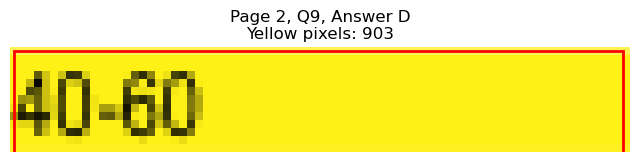


Page 2, Q9 - Selected Answer: D (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=68.3, y0=632.2, x1=137.5, y1=644.9
Page 2, Q10, A: Yellow pixels: 1290
Page 2, Q10, A: Total non-white pixels: 1560
Page 2, Q10, A: Yellow percentage: 82.7%


Page 2, Q10 - B: Detected box: x0=68.3, y0=644.9, x1=217.2, y1=657.5
Page 2, Q10, B: Yellow pixels: 0
Page 2, Q10, B: Total non-white pixels: 749
Page 2, Q10, B: Yellow percentage: 0.0%


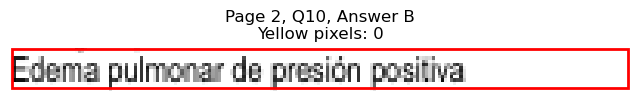

Page 2, Q10 - C: Detected box: x0=327.5, y0=632.2, x1=394.4, y1=644.9
Page 2, Q10, C: Yellow pixels: 0
Page 2, Q10, C: Total non-white pixels: 365
Page 2, Q10, C: Yellow percentage: 0.0%


Page 2, Q10 - D: Detected box: x0=327.5, y0=644.9, x1=375.7, y1=657.5
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 251
Page 2, Q10, D: Yellow percentage: 0.0%



Page 2, Q10 - Selected Answer: A (based on yellow pixel count)




Page 2, Q11 - A: Detected box: x0=68.3, y0=720.6, x1=245.3, y1=733.2
Page 2, Q11, A: Yellow pixels: 213
Page 2, Q11, A: Total non-white pixels: 1074
Page 2, Q11, A: Yellow percentage: 19.8%


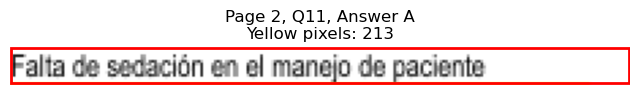

Page 2, Q11 - B: Detected box: x0=68.3, y0=733.2, x1=240.3, y1=745.8
Page 2, Q11, B: Yellow pixels: 2108
Page 2, Q11, B: Total non-white pixels: 2782
Page 2, Q11, B: Yellow percentage: 75.8%


Page 2, Q11 - C: Detected box: x0=327.5, y0=720.6, x1=407.8, y1=733.2
Page 2, Q11, C: Yellow pixels: 0
Page 2, Q11, C: Total non-white pixels: 406
Page 2, Q11, C: Yellow percentage: 0.0%


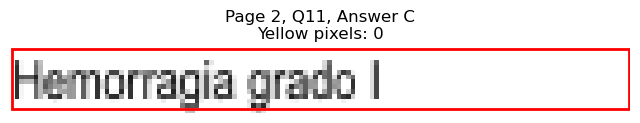

Page 2, Q11 - D: Detected box: x0=327.5, y0=733.2, x1=426.8, y1=745.8
Page 2, Q11, D: Yellow pixels: 0
Page 2, Q11, D: Total non-white pixels: 532
Page 2, Q11, D: Yellow percentage: 0.0%


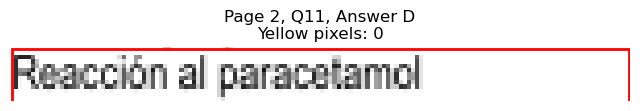


Page 2, Q11 - Selected Answer: B (based on yellow pixel count)





Page 3: Found 11 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=95.9, y1=114.7
Page 3, Q1, A: Yellow pixels: 3
Page 3, Q1, A: Total non-white pixels: 215
Page 3, Q1, A: Yellow percentage: 1.4%


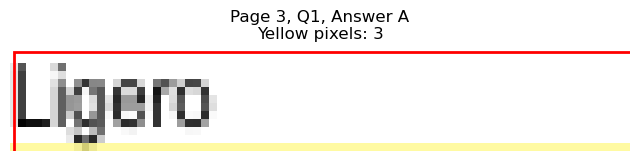

Page 3, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=111.4, y1=127.3
Page 3, Q1, B: Yellow pixels: 944
Page 3, Q1, B: Total non-white pixels: 1316
Page 3, Q1, B: Yellow percentage: 71.7%


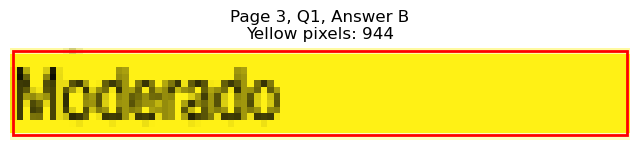

Page 3, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=372.3, y1=114.7
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 234
Page 3, Q1, C: Yellow percentage: 0.0%


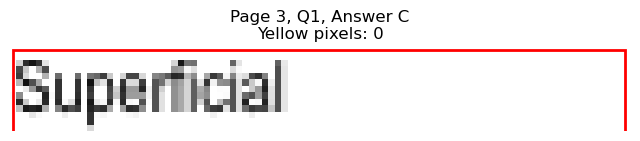

Page 3, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=366.7, y1=127.3
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 194
Page 3, Q1, D: Yellow percentage: 0.0%


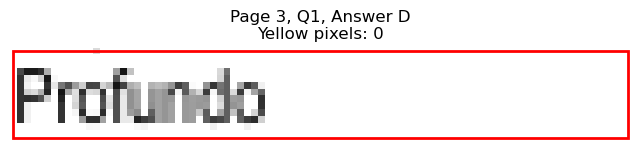


Page 3, Q1 - Selected Answer: B (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=152.5, x1=144.5, y1=165.2
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 392
Page 3, Q2, A: Yellow percentage: 0.0%


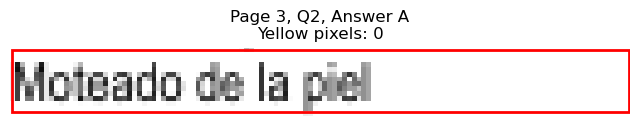

Page 3, Q2 - B: Detected box: x0=68.3, y0=165.1, x1=113.4, y1=177.8
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 238
Page 3, Q2, B: Yellow percentage: 0.0%


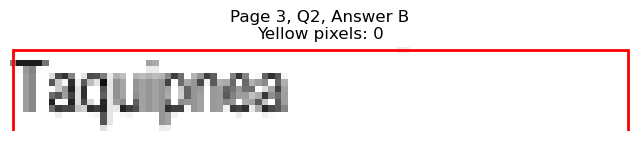

Page 3, Q2 - C: Detected box: x0=327.5, y0=152.5, x1=387.7, y1=165.2
Page 3, Q2, C: Yellow pixels: 111
Page 3, Q2, C: Total non-white pixels: 412
Page 3, Q2, C: Yellow percentage: 26.9%


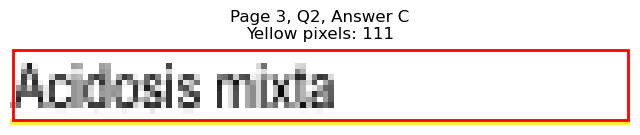

Page 3, Q2 - D: Detected box: x0=327.5, y0=165.1, x1=388.3, y1=177.8
Page 3, Q2, D: Yellow pixels: 1182
Page 3, Q2, D: Total non-white pixels: 1456
Page 3, Q2, D: Yellow percentage: 81.2%


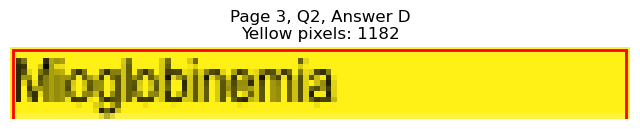


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=202.9, x1=177.1, y1=215.6
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 553
Page 3, Q3, A: Yellow percentage: 0.0%


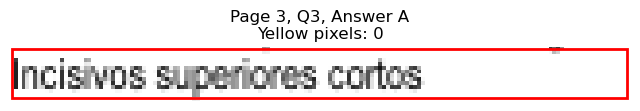

Page 3, Q3 - B: Detected box: x0=68.3, y0=215.7, x1=156.0, y1=228.3
Page 3, Q3, B: Yellow pixels: 1337
Page 3, Q3, B: Total non-white pixels: 1946
Page 3, Q3, B: Yellow percentage: 68.7%


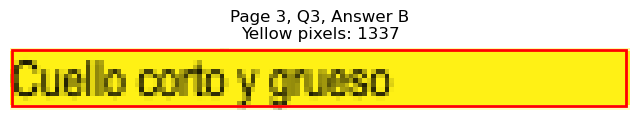

Page 3, Q3 - C: Detected box: x0=327.5, y0=202.9, x1=443.3, y1=215.6
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 593
Page 3, Q3, C: Yellow percentage: 0.0%


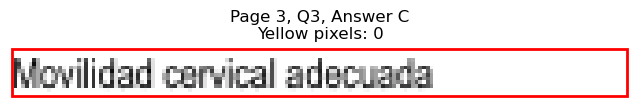

Page 3, Q3 - D: Detected box: x0=327.5, y0=215.7, x1=378.7, y1=228.3
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 276
Page 3, Q3, D: Yellow percentage: 0.0%


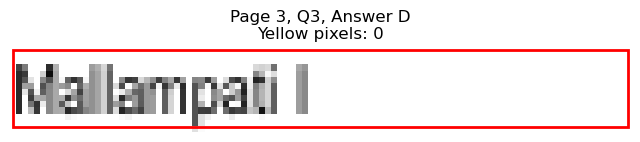


Page 3, Q3 - Selected Answer: B (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=266.1, x1=85.8, y1=278.7
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 78
Page 3, Q4, A: Yellow percentage: 0.0%


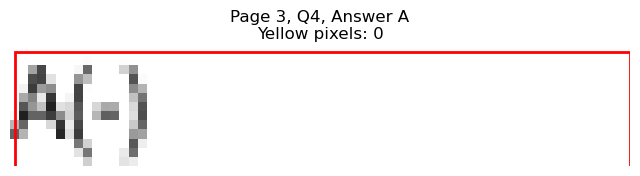

Page 3, Q4 - B: Detected box: x0=68.3, y0=278.8, x1=89.1, y1=291.5
Page 3, Q4, B: Yellow pixels: 864
Page 3, Q4, B: Total non-white pixels: 1008
Page 3, Q4, B: Yellow percentage: 85.7%


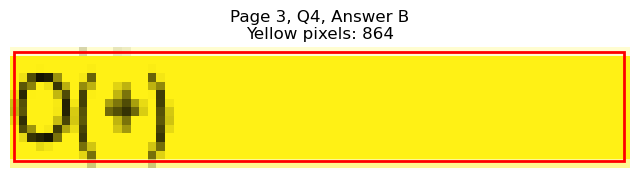

Page 3, Q4 - C: Detected box: x0=327.5, y0=266.1, x1=342.1, y1=278.7
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 68
Page 3, Q4, C: Yellow percentage: 0.0%


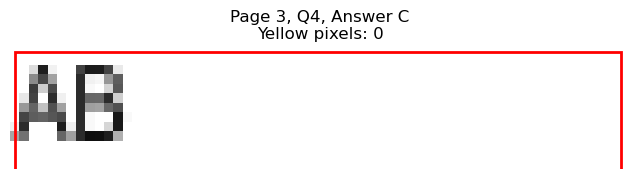

Page 3, Q4 - D: Detected box: x0=327.5, y0=278.8, x1=347.3, y1=291.5
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 91
Page 3, Q4, D: Yellow percentage: 0.0%


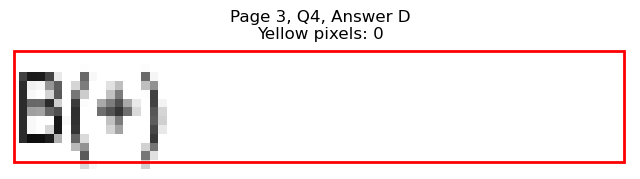


Page 3, Q4 - Selected Answer: B (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=316.6, x1=139.0, y1=329.3
Page 3, Q5, A: Yellow pixels: 121
Page 3, Q5, A: Total non-white pixels: 460
Page 3, Q5, A: Yellow percentage: 26.3%


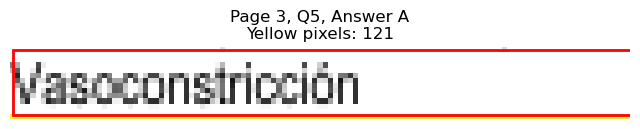

Page 3, Q5 - B: Detected box: x0=68.3, y0=329.2, x1=129.5, y1=341.9
Page 3, Q5, B: Yellow pixels: 1185
Page 3, Q5, B: Total non-white pixels: 1456
Page 3, Q5, B: Yellow percentage: 81.4%


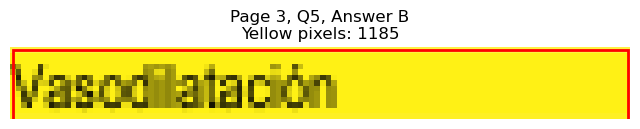

Page 3, Q5 - C: Detected box: x0=327.5, y0=316.6, x1=400.7, y1=329.3
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 357
Page 3, Q5, C: Yellow percentage: 0.0%


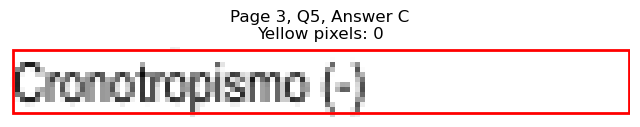

Page 3, Q5 - D: Detected box: x0=327.5, y0=329.2, x1=391.0, y1=341.9
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 311
Page 3, Q5, D: Yellow percentage: 0.0%


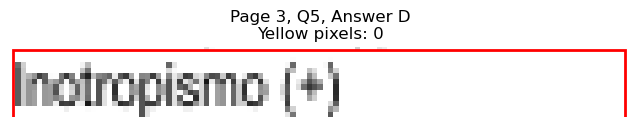


Page 3, Q5 - Selected Answer: B (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=392.3, x1=128.5, y1=405.0
Page 3, Q6, A: Yellow pixels: 1199
Page 3, Q6, A: Total non-white pixels: 1443
Page 3, Q6, A: Yellow percentage: 83.1%


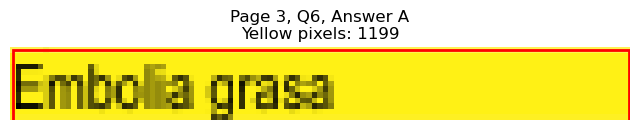

Page 3, Q6 - B: Detected box: x0=68.3, y0=404.9, x1=259.1, y1=417.6
Page 3, Q6, B: Yellow pixels: 209
Page 3, Q6, B: Total non-white pixels: 1158
Page 3, Q6, B: Yellow percentage: 18.0%


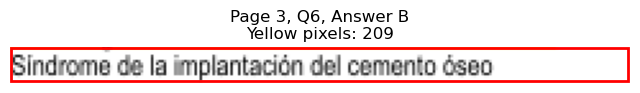

Page 3, Q6 - C: Detected box: x0=327.5, y0=392.3, x1=444.9, y1=405.0
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 566
Page 3, Q6, C: Yellow percentage: 0.0%


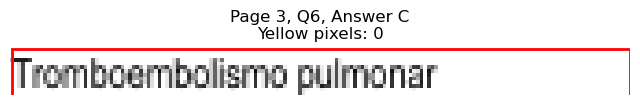

Page 3, Q6 - D: Detected box: x0=327.5, y0=404.9, x1=432.9, y1=417.6
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 520
Page 3, Q6, D: Yellow percentage: 0.0%


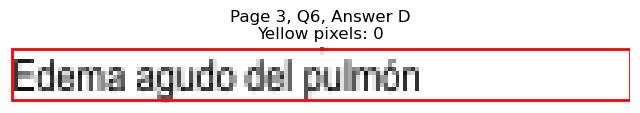


Page 3, Q6 - Selected Answer: A (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=455.5, x1=111.4, y1=468.1
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 220
Page 3, Q7, A: Yellow percentage: 0.0%


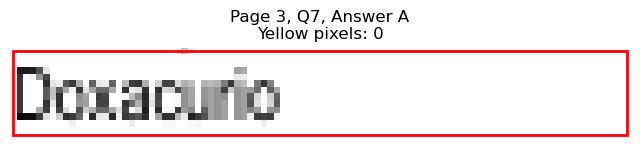

Page 3, Q7 - B: Detected box: x0=68.3, y0=468.1, x1=121.9, y1=480.7
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 255
Page 3, Q7, B: Yellow percentage: 0.0%


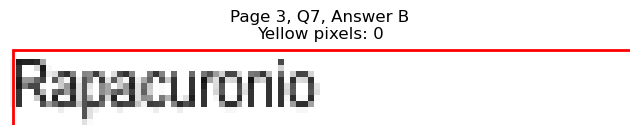

Page 3, Q7 - C: Detected box: x0=327.5, y0=455.5, x1=378.2, y1=468.1
Page 3, Q7, C: Yellow pixels: 1128
Page 3, Q7, C: Total non-white pixels: 1428
Page 3, Q7, C: Yellow percentage: 79.0%


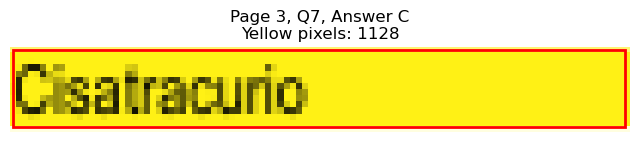

Page 3, Q7 - D: Detected box: x0=327.5, y0=468.1, x1=383.2, y1=480.7
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 385
Page 3, Q7, D: Yellow percentage: 0.0%


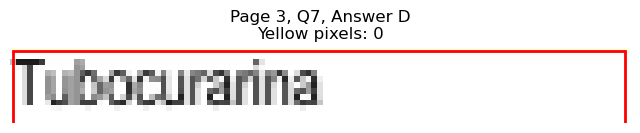


Page 3, Q7 - Selected Answer: C (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=518.6, x1=90.4, y1=531.2
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 125
Page 3, Q8, A: Yellow percentage: 0.0%


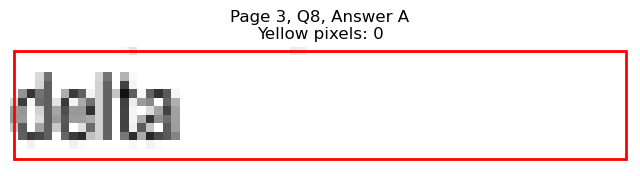

Page 3, Q8 - B: Detected box: x0=68.3, y0=531.2, x1=77.3, y1=543.8
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 33
Page 3, Q8, B: Yellow percentage: 0.0%


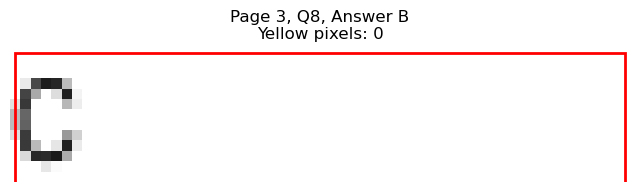

Page 3, Q8 - C: Detected box: x0=315.4, y0=518.6, x1=324.4, y1=531.2
Page 3, Q8, C: Yellow pixels: 725
Page 3, Q8, C: Total non-white pixels: 840
Page 3, Q8, C: Yellow percentage: 86.3%


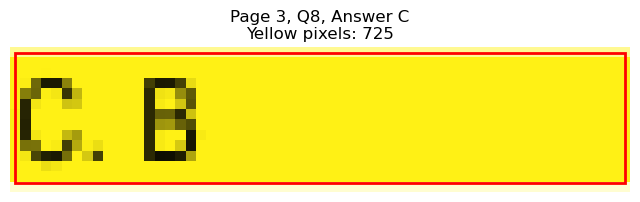

Page 3, Q8 - D: Detected box: x0=315.4, y0=531.2, x1=324.4, y1=543.8
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 131
Page 3, Q8, D: Yellow percentage: 0.0%


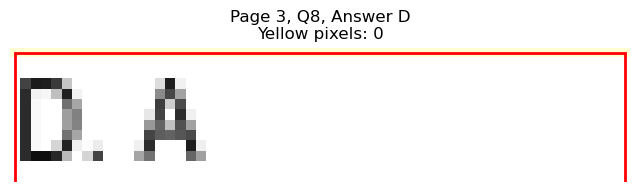


Page 3, Q8 - Selected Answer: C (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=581.7, x1=79.3, y1=594.4
Page 3, Q9, A: Yellow pixels: 713
Page 3, Q9, A: Total non-white pixels: 868
Page 3, Q9, A: Yellow percentage: 82.1%


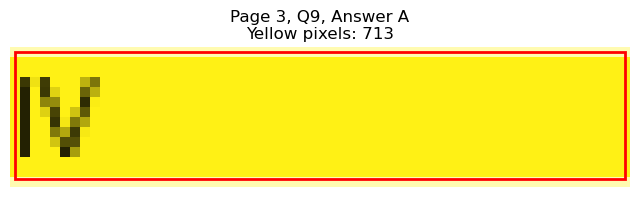

Page 3, Q9 - B: Detected box: x0=68.3, y0=594.3, x1=76.8, y1=607.0
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 87
Page 3, Q9, B: Yellow percentage: 0.0%


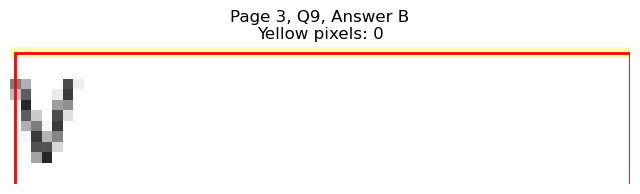

Page 3, Q9 - C: Detected box: x0=315.4, y0=581.7, x1=324.4, y1=594.4
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 71
Page 3, Q9, C: Yellow percentage: 0.0%


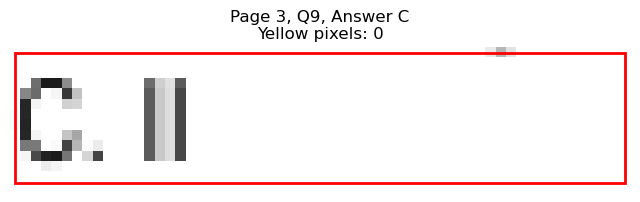

Page 3, Q9 - D: Detected box: x0=327.5, y0=594.3, x1=337.6, y1=607.0
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 48
Page 3, Q9, D: Yellow percentage: 0.0%


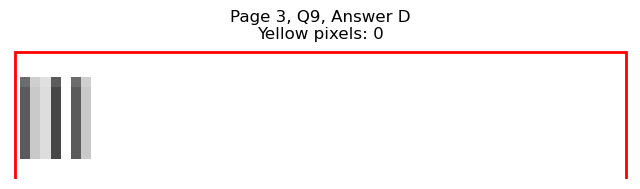


Page 3, Q9 - Selected Answer: A (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=68.3, y0=632.2, x1=122.4, y1=644.9
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 258
Page 3, Q10, A: Yellow percentage: 0.0%


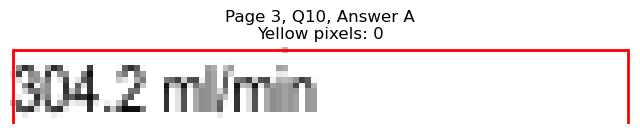

Page 3, Q10 - B: Detected box: x0=68.3, y0=644.9, x1=117.5, y1=657.5
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 228
Page 3, Q10, B: Yellow percentage: 0.0%


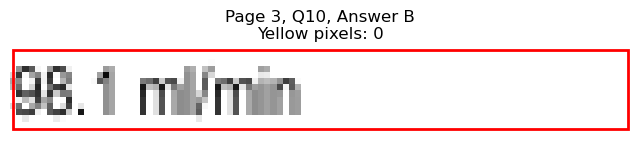

Page 3, Q10 - C: Detected box: x0=327.5, y0=632.2, x1=381.7, y1=644.9
Page 3, Q10, C: Yellow pixels: 1183
Page 3, Q10, C: Total non-white pixels: 1365
Page 3, Q10, C: Yellow percentage: 86.7%


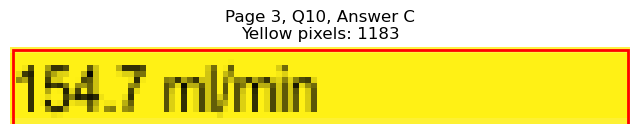

Page 3, Q10 - D: Detected box: x0=327.5, y0=644.9, x1=381.7, y1=657.5
Page 3, Q10, D: Yellow pixels: 0
Page 3, Q10, D: Total non-white pixels: 269
Page 3, Q10, D: Yellow percentage: 0.0%



Page 3, Q10 - Selected Answer: C (based on yellow pixel count)




Page 3, Q11 - A: Detected box: x0=68.3, y0=695.4, x1=217.2, y1=708.0
Page 3, Q11, A: Yellow pixels: 200
Page 3, Q11, A: Total non-white pixels: 1146
Page 3, Q11, A: Yellow percentage: 17.5%


Page 3, Q11 - B: Detected box: x0=68.3, y0=708.0, x1=202.2, y1=720.6
Page 3, Q11, B: Yellow pixels: 1831
Page 3, Q11, B: Total non-white pixels: 2590
Page 3, Q11, B: Yellow percentage: 70.7%


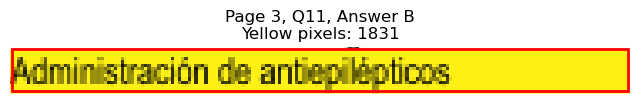

Page 3, Q11 - C: Detected box: x0=68.8, y0=720.6, x1=299.1, y1=733.2
Page 3, Q11, C: Yellow pixels: 282
Page 3, Q11, C: Total non-white pixels: 1415
Page 3, Q11, C: Yellow percentage: 19.9%


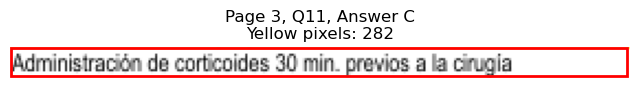

Page 3, Q11 - D: Detected box: x0=68.8, y0=733.2, x1=247.4, y1=745.8
Page 3, Q11, D: Yellow pixels: 0
Page 3, Q11, D: Total non-white pixels: 904
Page 3, Q11, D: Yellow percentage: 0.0%


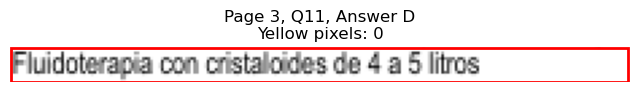


Page 3, Q11 - Selected Answer: B (based on yellow pixel count)





Page 4: Found 11 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=189.1, y1=102.1
Page 4, Q1, A: Yellow pixels: 1788
Page 4, Q1, A: Total non-white pixels: 2408
Page 4, Q1, A: Yellow percentage: 74.3%


Page 4, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=243.4, y1=114.7
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 1029
Page 4, Q1, B: Yellow percentage: 0.0%


Page 4, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=485.1, y1=102.1
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 762
Page 4, Q1, C: Yellow percentage: 0.0%


Page 4, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=528.7, y1=114.7
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 1008
Page 4, Q1, D: Yellow percentage: 0.0%



Page 4, Q1 - Selected Answer: A (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=151.2, y1=177.8
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 434
Page 4, Q2, A: Yellow percentage: 0.0%


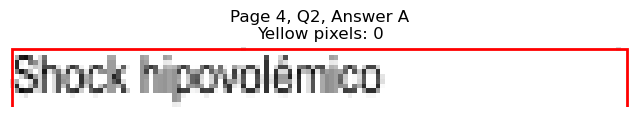

Page 4, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=132.6, y1=190.4
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 317
Page 4, Q2, B: Yellow percentage: 0.0%


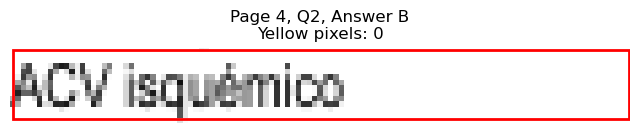

Page 4, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=431.0, y1=177.8
Page 4, Q2, C: Yellow pixels: 1
Page 4, Q2, C: Total non-white pixels: 667
Page 4, Q2, C: Yellow percentage: 0.1%


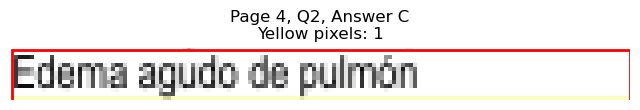

Page 4, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=387.8, y1=190.4
Page 4, Q2, D: Yellow pixels: 1203
Page 4, Q2, D: Total non-white pixels: 1554
Page 4, Q2, D: Yellow percentage: 77.4%


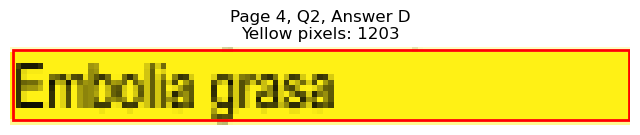


Page 4, Q2 - Selected Answer: D (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=76.8, y1=240.9
Page 4, Q3, A: Yellow pixels: 742
Page 4, Q3, A: Total non-white pixels: 767
Page 4, Q3, A: Yellow percentage: 96.7%


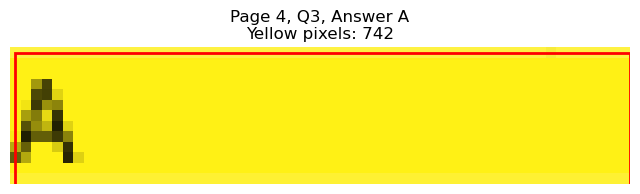

Page 4, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=77.3, y1=253.5
Page 4, Q3, B: Yellow pixels: 60
Page 4, Q3, B: Total non-white pixels: 98
Page 4, Q3, B: Yellow percentage: 61.2%


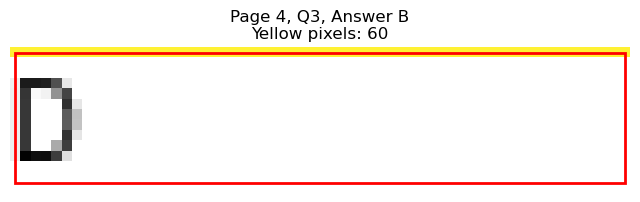

Page 4, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=336.5, y1=240.9
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 33
Page 4, Q3, C: Yellow percentage: 0.0%


Page 4, Q3 - D: Detected box: x0=315.4, y0=240.9, x1=324.4, y1=253.5
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 77
Page 4, Q3, D: Yellow percentage: 0.0%


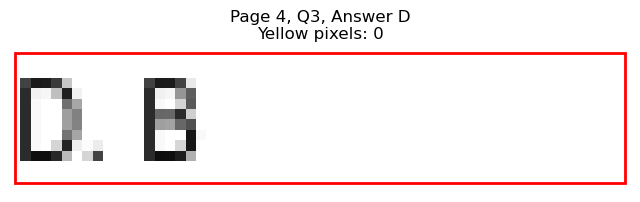


Page 4, Q3 - Selected Answer: A (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=56.6, y0=291.4, x1=65.2, y1=304.1
Page 4, Q4, A: Yellow pixels: 60
Page 4, Q4, A: Total non-white pixels: 127
Page 4, Q4, A: Yellow percentage: 47.2%


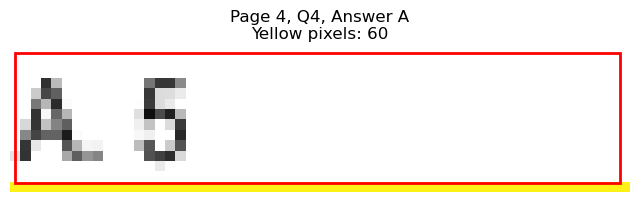

Page 4, Q4 - B: Detected box: x0=56.6, y0=304.0, x1=65.2, y1=316.7
Page 4, Q4, B: Yellow pixels: 722
Page 4, Q4, B: Total non-white pixels: 780
Page 4, Q4, B: Yellow percentage: 92.6%


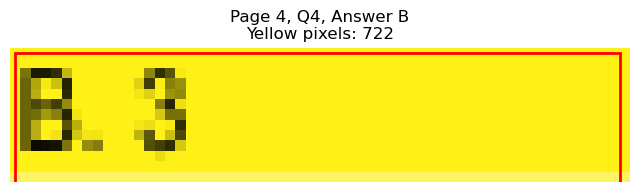

Page 4, Q4 - C: Detected box: x0=315.4, y0=291.4, x1=324.4, y1=304.1
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 58
Page 4, Q4, C: Yellow percentage: 0.0%


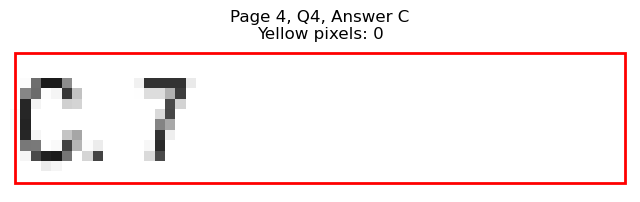

Page 4, Q4 - D: Detected box: x0=315.4, y0=304.0, x1=324.4, y1=316.7
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 53
Page 4, Q4, D: Yellow percentage: 0.0%


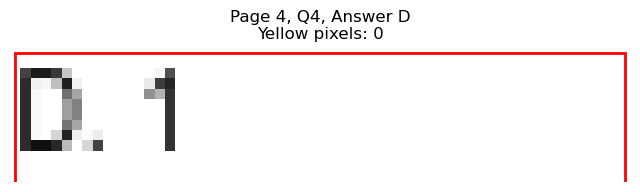


Page 4, Q4 - Selected Answer: B (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=354.5, x1=182.7, y1=367.2
Page 4, Q5, A: Yellow pixels: 165
Page 4, Q5, A: Total non-white pixels: 751
Page 4, Q5, A: Yellow percentage: 22.0%


Page 4, Q5 - B: Detected box: x0=68.3, y0=367.1, x1=238.0, y1=379.8
Page 4, Q5, B: Yellow pixels: 2111
Page 4, Q5, B: Total non-white pixels: 2782
Page 4, Q5, B: Yellow percentage: 75.9%


Page 4, Q5 - C: Detected box: x0=327.5, y0=354.5, x1=497.0, y1=367.2
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 851
Page 4, Q5, C: Yellow percentage: 0.0%


Page 4, Q5 - D: Detected box: x0=327.5, y0=367.1, x1=452.5, y1=379.8
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 660
Page 4, Q5, D: Yellow percentage: 0.0%



Page 4, Q5 - Selected Answer: B (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=417.6, x1=114.4, y1=430.3
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 248
Page 4, Q6, A: Yellow percentage: 0.0%


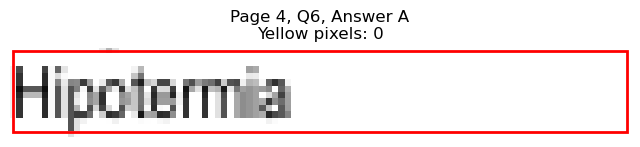

Page 4, Q6 - B: Detected box: x0=68.3, y0=430.2, x1=134.1, y1=442.9
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 338
Page 4, Q6, B: Yellow percentage: 0.0%


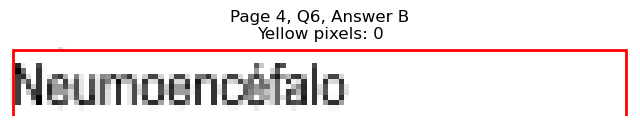

Page 4, Q6 - C: Detected box: x0=327.5, y0=417.6, x1=387.8, y1=430.3
Page 4, Q6, C: Yellow pixels: 111
Page 4, Q6, C: Total non-white pixels: 421
Page 4, Q6, C: Yellow percentage: 26.4%


Page 4, Q6 - D: Detected box: x0=327.5, y0=430.2, x1=430.9, y1=442.9
Page 4, Q6, D: Yellow pixels: 1600
Page 4, Q6, D: Total non-white pixels: 2002
Page 4, Q6, D: Yellow percentage: 79.9%


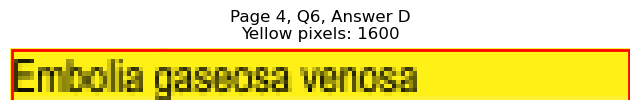


Page 4, Q6 - Selected Answer: D (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=480.8, x1=174.7, y1=493.4
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 481
Page 4, Q7, A: Yellow percentage: 0.0%


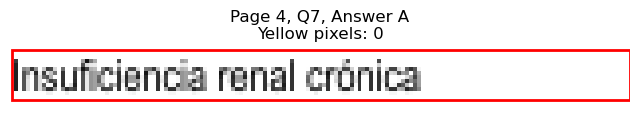

Page 4, Q7 - B: Detected box: x0=68.3, y0=493.4, x1=168.7, y1=506.0
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 505
Page 4, Q7, B: Yellow percentage: 0.0%


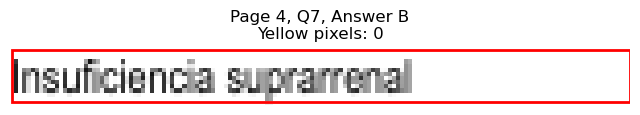

Page 4, Q7 - C: Detected box: x0=327.5, y0=480.8, x1=441.4, y1=493.4
Page 4, Q7, C: Yellow pixels: 165
Page 4, Q7, C: Total non-white pixels: 742
Page 4, Q7, C: Yellow percentage: 22.2%


Page 4, Q7 - D: Detected box: x0=327.5, y0=493.4, x1=422.8, y1=506.0
Page 4, Q7, D: Yellow pixels: 1529
Page 4, Q7, D: Total non-white pixels: 1901
Page 4, Q7, D: Yellow percentage: 80.4%



Page 4, Q7 - Selected Answer: D (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=531.2, x1=250.4, y1=543.8
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 924
Page 4, Q8, A: Yellow percentage: 0.0%


Page 4, Q8 - B: Detected box: x0=68.3, y0=543.9, x1=209.8, y1=556.6
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 709
Page 4, Q8, B: Yellow percentage: 0.0%


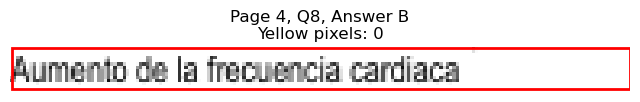

Page 4, Q8 - C: Detected box: x0=327.5, y0=531.2, x1=500.6, y1=543.8
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 895
Page 4, Q8, C: Yellow percentage: 0.0%


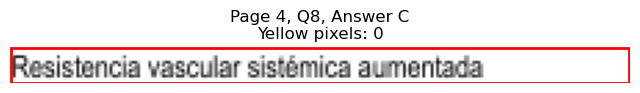

Page 4, Q8 - D: Detected box: x0=327.5, y0=543.9, x1=452.0, y1=556.6
Page 4, Q8, D: Yellow pixels: 1812
Page 4, Q8, D: Total non-white pixels: 2450
Page 4, Q8, D: Yellow percentage: 74.0%


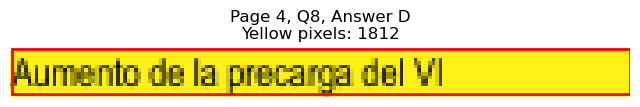


Page 4, Q8 - Selected Answer: D (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=607.0, x1=134.5, y1=619.7
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 342
Page 4, Q9, A: Yellow percentage: 0.0%


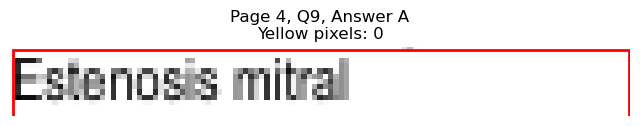

Page 4, Q9 - B: Detected box: x0=68.3, y0=619.6, x1=145.1, y1=632.3
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 363
Page 4, Q9, B: Yellow percentage: 0.0%


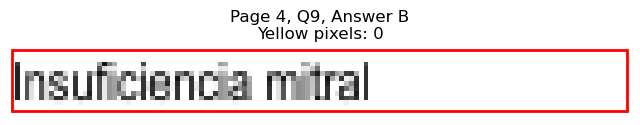

Page 4, Q9 - C: Detected box: x0=327.5, y0=607.0, x1=409.3, y1=619.7
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 566
Page 4, Q9, C: Yellow percentage: 0.0%


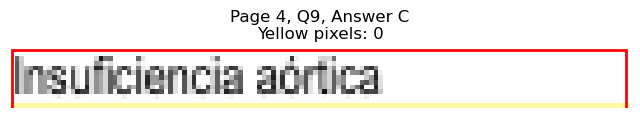

Page 4, Q9 - D: Detected box: x0=327.5, y0=619.6, x1=398.8, y1=632.3
Page 4, Q9, D: Yellow pixels: 1190
Page 4, Q9, D: Total non-white pixels: 1708
Page 4, Q9, D: Yellow percentage: 69.7%


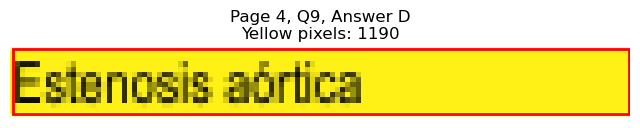


Page 4, Q9 - Selected Answer: D (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=68.3, y0=670.2, x1=129.5, y1=682.8
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 298
Page 4, Q10, A: Yellow percentage: 0.0%


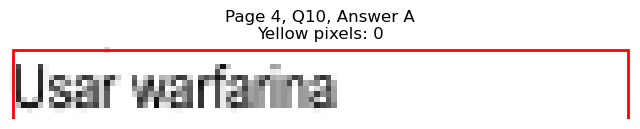

Page 4, Q10 - B: Detected box: x0=68.3, y0=682.8, x1=144.5, y1=695.4
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 348
Page 4, Q10, B: Yellow percentage: 0.0%


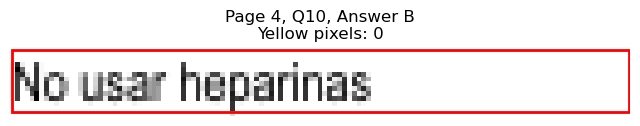

Page 4, Q10 - C: Detected box: x0=327.5, y0=670.2, x1=429.9, y1=682.8
Page 4, Q10, C: Yellow pixels: 1588
Page 4, Q10, C: Total non-white pixels: 1989
Page 4, Q10, C: Yellow percentage: 79.8%


Page 4, Q10 - D: Detected box: x0=327.5, y0=682.8, x1=469.1, y1=695.4
Page 4, Q10, D: Yellow pixels: 191
Page 4, Q10, D: Total non-white pixels: 911
Page 4, Q10, D: Yellow percentage: 21.0%


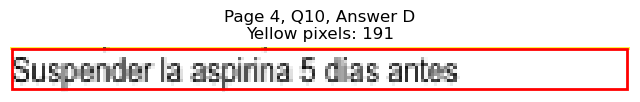


Page 4, Q10 - Selected Answer: C (based on yellow pixel count)




Page 4, Q11 - A: Detected box: x0=68.3, y0=733.2, x1=134.1, y1=745.8
Page 4, Q11, A: Yellow pixels: 1271
Page 4, Q11, A: Total non-white pixels: 1521
Page 4, Q11, A: Yellow percentage: 83.6%


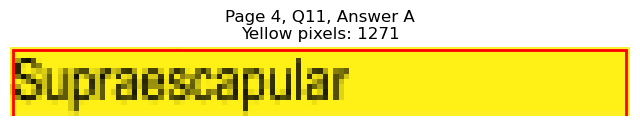

Page 4, Q11 - B: Detected box: x0=68.3, y0=745.9, x1=93.5, y1=758.6
Page 4, Q11, B: Yellow pixels: 76
Page 4, Q11, B: Total non-white pixels: 202
Page 4, Q11, B: Yellow percentage: 37.6%


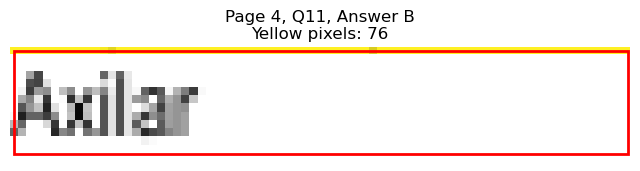

Page 4, Q11 - C: Detected box: x0=327.5, y0=733.2, x1=364.6, y1=745.8
Page 4, Q11, C: Yellow pixels: 0
Page 4, Q11, C: Total non-white pixels: 198
Page 4, Q11, C: Yellow percentage: 0.0%


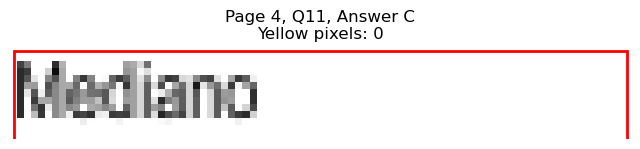

Page 4, Q11 - D: Detected box: x0=327.5, y0=745.9, x1=390.8, y1=758.6
Page 4, Q11, D: Yellow pixels: 0
Page 4, Q11, D: Total non-white pixels: 331
Page 4, Q11, D: Yellow percentage: 0.0%



Page 4, Q11 - Selected Answer: A (based on yellow pixel count)





Page 5: Found 13 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=162.6, y1=102.1
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 477
Page 5, Q1, A: Yellow percentage: 0.0%


Page 5, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=175.1, y1=114.7
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 509
Page 5, Q1, B: Yellow percentage: 0.0%


Page 5, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=426.3, y1=102.1
Page 5, Q1, C: Yellow pixels: 150
Page 5, Q1, C: Total non-white pixels: 644
Page 5, Q1, C: Yellow percentage: 23.3%


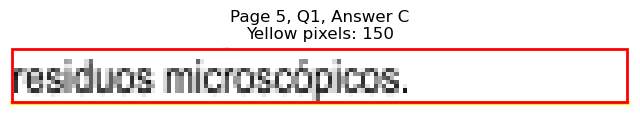

Page 5, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=413.3, y1=114.7
Page 5, Q1, D: Yellow pixels: 1446
Page 5, Q1, D: Total non-white pixels: 1781
Page 5, Q1, D: Yellow percentage: 81.2%


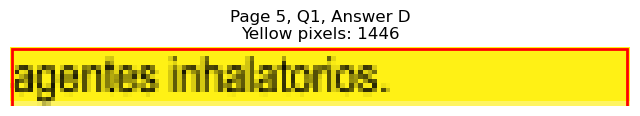


Page 5, Q1 - Selected Answer: D (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=139.9, x1=248.3, y1=152.6
Page 5, Q2, A: Yellow pixels: 213
Page 5, Q2, A: Total non-white pixels: 1154
Page 5, Q2, A: Yellow percentage: 18.5%


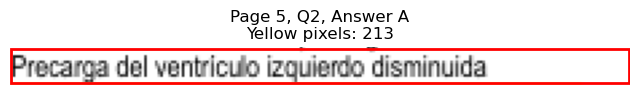

Page 5, Q2 - B: Detected box: x0=68.3, y0=152.5, x1=239.3, y1=165.2
Page 5, Q2, B: Yellow pixels: 2098
Page 5, Q2, B: Total non-white pixels: 2996
Page 5, Q2, B: Yellow percentage: 70.0%


Page 5, Q2 - C: Detected box: x0=327.5, y0=139.9, x1=456.9, y1=152.6
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 624
Page 5, Q2, C: Yellow percentage: 0.0%


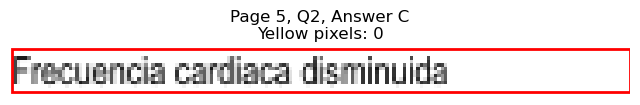

Page 5, Q2 - D: Detected box: x0=327.5, y0=152.5, x1=500.6, y1=165.2
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 872
Page 5, Q2, D: Yellow percentage: 0.0%



Page 5, Q2 - Selected Answer: B (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=190.3, x1=118.1, y1=203.0
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 235
Page 5, Q3, A: Yellow percentage: 0.0%


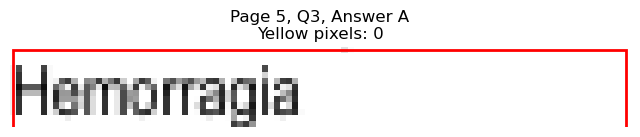

Page 5, Q3 - B: Detected box: x0=68.3, y0=202.9, x1=139.5, y1=215.6
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 347
Page 5, Q3, B: Yellow percentage: 0.0%


Page 5, Q3 - C: Detected box: x0=327.5, y0=190.3, x1=369.2, y1=203.0
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 305
Page 5, Q3, C: Yellow percentage: 0.0%


Page 5, Q3 - D: Detected box: x0=327.5, y0=202.9, x1=395.2, y1=215.6
Page 5, Q3, D: Yellow pixels: 1290
Page 5, Q3, D: Total non-white pixels: 1666
Page 5, Q3, D: Yellow percentage: 77.4%



Page 5, Q3 - Selected Answer: D (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=240.9, x1=179.7, y1=253.5
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 534
Page 5, Q4, A: Yellow percentage: 0.0%


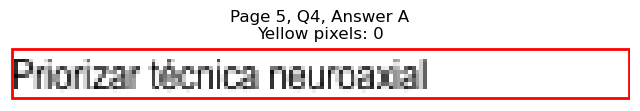

Page 5, Q4 - B: Detected box: x0=68.3, y0=253.5, x1=151.6, y1=266.1
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 449
Page 5, Q4, B: Yellow percentage: 0.0%


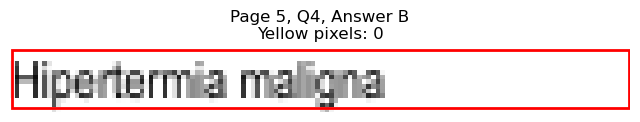

Page 5, Q4 - C: Detected box: x0=327.5, y0=240.9, x1=460.9, y1=253.5
Page 5, Q4, C: Yellow pixels: 1845
Page 5, Q4, C: Total non-white pixels: 2576
Page 5, Q4, C: Yellow percentage: 71.6%


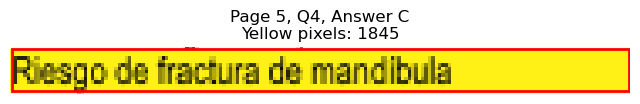

Page 5, Q4 - D: Detected box: x0=327.5, y0=253.5, x1=470.0, y1=266.1
Page 5, Q4, D: Yellow pixels: 193
Page 5, Q4, D: Total non-white pixels: 858
Page 5, Q4, D: Yellow percentage: 22.5%


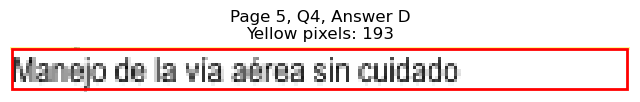


Page 5, Q4 - Selected Answer: C (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=291.4, x1=159.6, y1=304.1
Page 5, Q5, A: Yellow pixels: 142
Page 5, Q5, A: Total non-white pixels: 574
Page 5, Q5, A: Yellow percentage: 24.7%


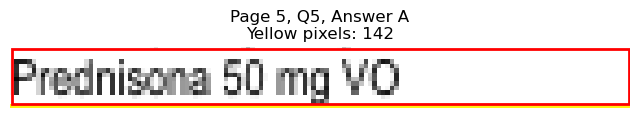

Page 5, Q5 - B: Detected box: x0=68.3, y0=304.0, x1=167.5, y1=316.7
Page 5, Q5, B: Yellow pixels: 1583
Page 5, Q5, B: Total non-white pixels: 1950
Page 5, Q5, B: Yellow percentage: 81.2%


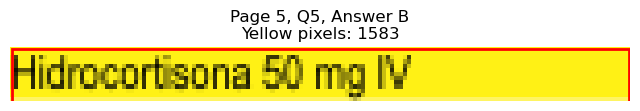

Page 5, Q5 - C: Detected box: x0=327.5, y0=291.4, x1=422.8, y1=304.1
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 471
Page 5, Q5, C: Yellow percentage: 0.0%


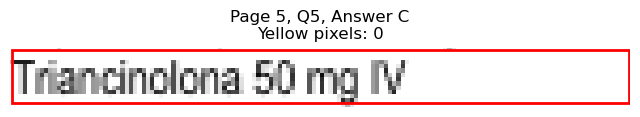

Page 5, Q5 - D: Detected box: x0=327.5, y0=304.0, x1=431.8, y1=316.7
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 524
Page 5, Q5, D: Yellow percentage: 0.0%


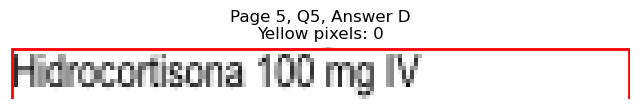


Page 5, Q5 - Selected Answer: B (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=341.9, x1=150.6, y1=354.6
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 403
Page 5, Q6, A: Yellow percentage: 0.0%


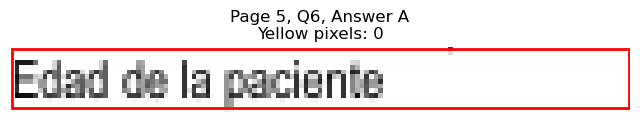

Page 5, Q6 - B: Detected box: x0=68.3, y0=354.5, x1=230.8, y1=367.2
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 815
Page 5, Q6, B: Yellow percentage: 0.0%


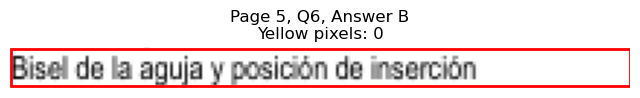

Page 5, Q6 - C: Detected box: x0=327.5, y0=341.9, x1=465.4, y1=354.6
Page 5, Q6, C: Yellow pixels: 1930
Page 5, Q6, C: Total non-white pixels: 2646
Page 5, Q6, C: Yellow percentage: 72.9%


Page 5, Q6 - D: Detected box: x0=327.5, y0=354.5, x1=409.9, y1=367.2
Page 5, Q6, D: Yellow pixels: 133
Page 5, Q6, D: Total non-white pixels: 544
Page 5, Q6, D: Yellow percentage: 24.4%



Page 5, Q6 - Selected Answer: C (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=392.3, x1=159.1, y1=405.0
Page 5, Q7, A: Yellow pixels: 1473
Page 5, Q7, A: Total non-white pixels: 1846
Page 5, Q7, A: Yellow percentage: 79.8%


Page 5, Q7 - B: Detected box: x0=68.3, y0=404.9, x1=101.9, y1=417.6
Page 5, Q7, B: Yellow pixels: 79
Page 5, Q7, B: Total non-white pixels: 269
Page 5, Q7, B: Yellow percentage: 29.4%


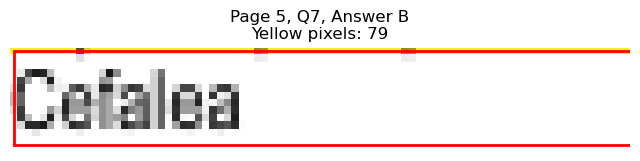

Page 5, Q7 - C: Detected box: x0=327.5, y0=392.3, x1=361.1, y1=405.0
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 176
Page 5, Q7, C: Yellow percentage: 0.0%


Page 5, Q7 - D: Detected box: x0=327.5, y0=404.9, x1=390.2, y1=417.6
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 334
Page 5, Q7, D: Yellow percentage: 0.0%



Page 5, Q7 - Selected Answer: A (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=119.2, y0=442.8, x1=176.3, y1=455.5
Page 5, Q8, A: Yellow pixels: 1195
Page 5, Q8, A: Total non-white pixels: 1512
Page 5, Q8, A: Yellow percentage: 79.0%


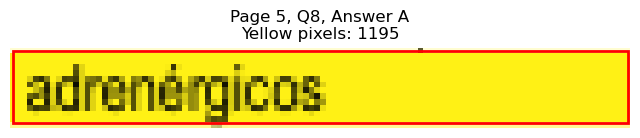

Page 5, Q8 - B: Detected box: x0=128.2, y0=455.5, x1=185.3, y1=468.1
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 301
Page 5, Q8, B: Yellow percentage: 0.0%


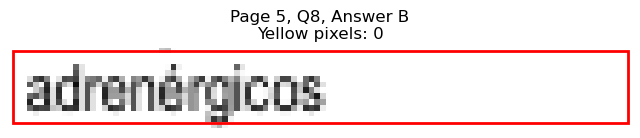

Page 5, Q8 - C: Detected box: x0=327.5, y0=442.8, x1=454.0, y1=455.5
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 625
Page 5, Q8, C: Yellow percentage: 0.0%


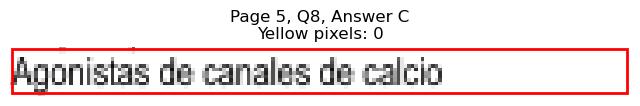

Page 5, Q8 - D: Detected box: x0=327.5, y0=455.5, x1=396.8, y1=468.1
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 649
Page 5, Q8, D: Yellow percentage: 0.0%


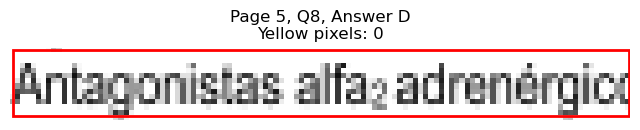


Page 5, Q8 - Selected Answer: A (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=506.0, x1=201.8, y1=518.6
Page 5, Q9, A: Yellow pixels: 1869
Page 5, Q9, A: Total non-white pixels: 2576
Page 5, Q9, A: Yellow percentage: 72.6%


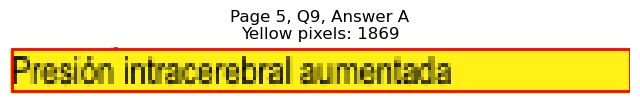

Page 5, Q9 - B: Detected box: x0=68.3, y0=518.6, x1=140.1, y1=531.2
Page 5, Q9, B: Yellow pixels: 123
Page 5, Q9, B: Total non-white pixels: 500
Page 5, Q9, B: Yellow percentage: 24.6%


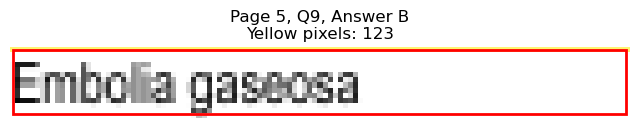

Page 5, Q9 - C: Detected box: x0=327.5, y0=506.0, x1=479.0, y1=518.6
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 810
Page 5, Q9, C: Yellow percentage: 0.0%


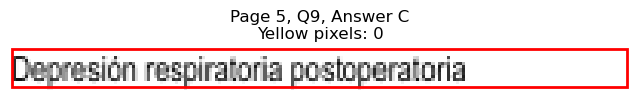

Page 5, Q9 - D: Detected box: x0=327.5, y0=518.6, x1=432.4, y1=531.2
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 536
Page 5, Q9, D: Yellow percentage: 0.0%


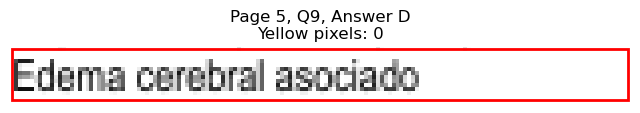


Page 5, Q9 - Selected Answer: A (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=68.3, y0=556.5, x1=136.5, y1=569.2
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 368
Page 5, Q10, A: Yellow percentage: 0.0%


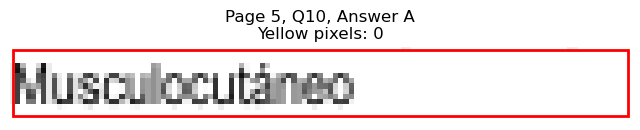

Page 5, Q10 - B: Detected box: x0=68.3, y0=569.1, x1=97.5, y1=581.8
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 150
Page 5, Q10, B: Yellow percentage: 0.0%


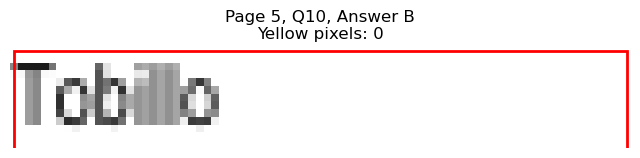

Page 5, Q10 - C: Detected box: x0=327.5, y0=556.5, x1=357.7, y1=569.2
Page 5, Q10, C: Yellow pixels: 930
Page 5, Q10, C: Total non-white pixels: 1134
Page 5, Q10, C: Yellow percentage: 82.0%


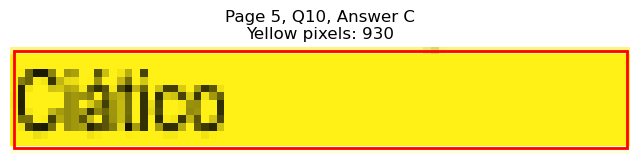

Page 5, Q10 - D: Detected box: x0=327.5, y0=569.1, x1=366.2, y1=581.8
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 272
Page 5, Q10, D: Yellow percentage: 0.0%


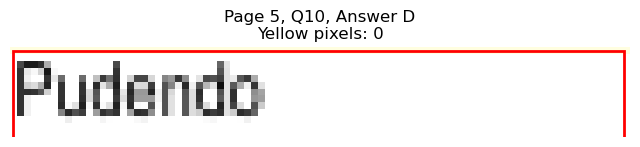


Page 5, Q10 - Selected Answer: C (based on yellow pixel count)




Page 5, Q11 - A: Detected box: x0=68.3, y0=619.6, x1=211.2, y1=632.3
Page 5, Q11, A: Yellow pixels: 0
Page 5, Q11, A: Total non-white pixels: 714
Page 5, Q11, A: Yellow percentage: 0.0%


Page 5, Q11 - B: Detected box: x0=68.3, y0=632.2, x1=244.4, y1=644.9
Page 5, Q11, B: Yellow pixels: 0
Page 5, Q11, B: Total non-white pixels: 839
Page 5, Q11, B: Yellow percentage: 0.0%


Page 5, Q11 - C: Detected box: x0=327.5, y0=619.6, x1=428.5, y1=632.3
Page 5, Q11, C: Yellow pixels: 152
Page 5, Q11, C: Total non-white pixels: 645
Page 5, Q11, C: Yellow percentage: 23.6%


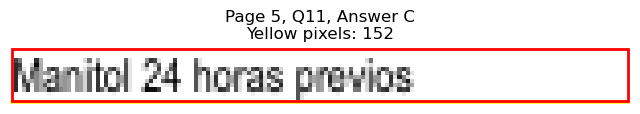

Page 5, Q11 - D: Detected box: x0=327.5, y0=632.2, x1=441.9, y1=644.9
Page 5, Q11, D: Yellow pixels: 1698
Page 5, Q11, D: Total non-white pixels: 2145
Page 5, Q11, D: Yellow percentage: 79.2%


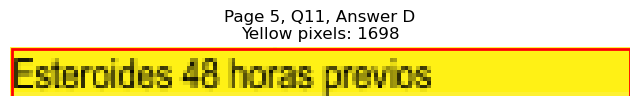


Page 5, Q11 - Selected Answer: D (based on yellow pixel count)




Page 5, Q12 - A: Detected box: x0=56.6, y0=670.1, x1=65.2, y1=682.7
Page 5, Q12, A: Yellow pixels: 732
Page 5, Q12, A: Total non-white pixels: 780
Page 5, Q12, A: Yellow percentage: 93.8%


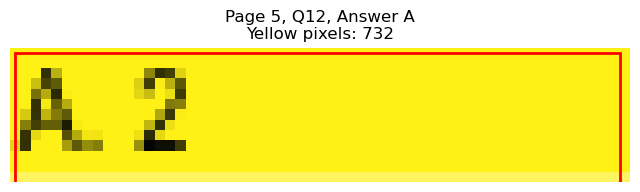

Page 5, Q12 - B: Detected box: x0=56.6, y0=682.7, x1=65.2, y1=695.3
Page 5, Q12, B: Yellow pixels: 60
Page 5, Q12, B: Total non-white pixels: 136
Page 5, Q12, B: Yellow percentage: 44.1%


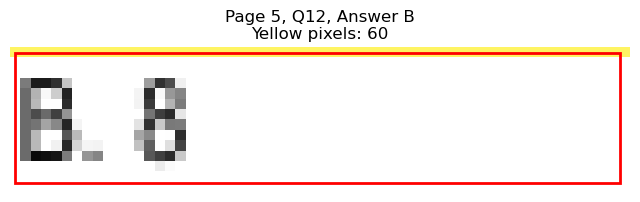

Page 5, Q12 - C: Detected box: x0=315.4, y0=670.1, x1=324.4, y1=682.7
Page 5, Q12, C: Yellow pixels: 0
Page 5, Q12, C: Total non-white pixels: 52
Page 5, Q12, C: Yellow percentage: 0.0%


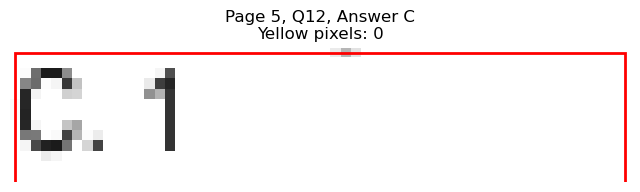

Page 5, Q12 - D: Detected box: x0=327.5, y0=682.7, x1=340.1, y1=695.3
Page 5, Q12, D: Yellow pixels: 0
Page 5, Q12, D: Total non-white pixels: 55
Page 5, Q12, D: Yellow percentage: 0.0%


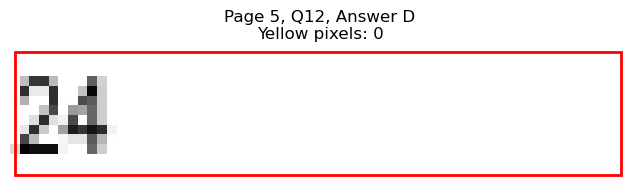


Page 5, Q12 - Selected Answer: A (based on yellow pixel count)




Page 5, Q13 - A: Detected box: x0=68.3, y0=720.6, x1=170.7, y1=733.2
Page 5, Q13, A: Yellow pixels: 1604
Page 5, Q13, A: Total non-white pixels: 2142
Page 5, Q13, A: Yellow percentage: 74.9%


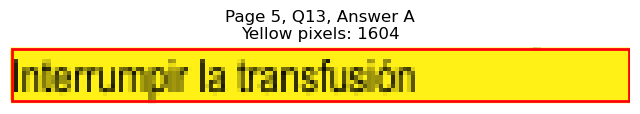

Page 5, Q13 - B: Detected box: x0=68.3, y0=733.2, x1=127.0, y1=745.8
Page 5, Q13, B: Yellow pixels: 0
Page 5, Q13, B: Total non-white pixels: 405
Page 5, Q13, B: Yellow percentage: 0.0%


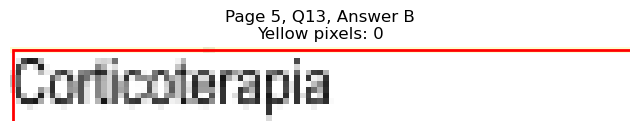

Page 5, Q13 - C: Detected box: x0=327.5, y0=720.6, x1=416.8, y1=733.2
Page 5, Q13, C: Yellow pixels: 0
Page 5, Q13, C: Total non-white pixels: 475
Page 5, Q13, C: Yellow percentage: 0.0%


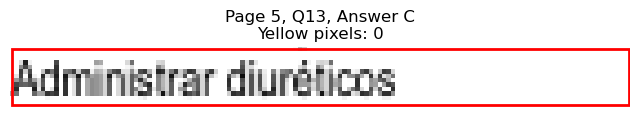

Page 5, Q13 - D: Detected box: x0=327.5, y0=733.2, x1=412.3, y1=745.8
Page 5, Q13, D: Yellow pixels: 0
Page 5, Q13, D: Total non-white pixels: 405
Page 5, Q13, D: Yellow percentage: 0.0%


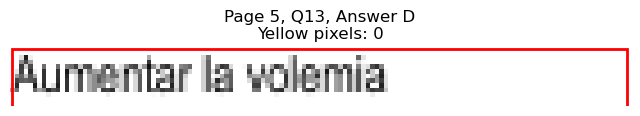


Page 5, Q13 - Selected Answer: A (based on yellow pixel count)





Page 6: Found 11 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=192.1, y1=114.7
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 576
Page 6, Q1, A: Yellow percentage: 0.0%


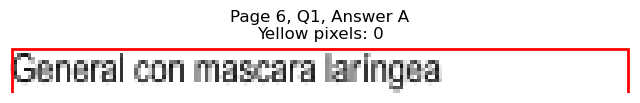

Page 6, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=109.9, y1=127.3
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 221
Page 6, Q1, B: Yellow percentage: 0.0%


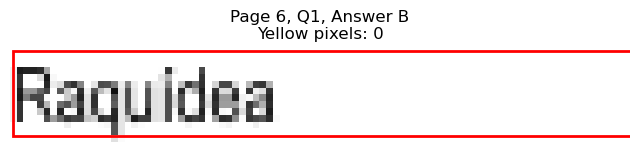

Page 6, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=358.6, y1=114.7
Page 6, Q1, C: Yellow pixels: 928
Page 6, Q1, C: Total non-white pixels: 1066
Page 6, Q1, C: Yellow percentage: 87.1%


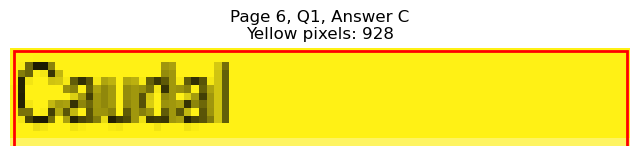

Page 6, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=396.8, y1=127.3
Page 6, Q1, D: Yellow pixels: 120
Page 6, Q1, D: Total non-white pixels: 431
Page 6, Q1, D: Yellow percentage: 27.8%


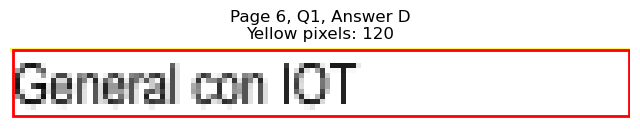


Page 6, Q1 - Selected Answer: C (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=282.4, y1=177.8
Page 6, Q2, A: Yellow pixels: 2590
Page 6, Q2, A: Total non-white pixels: 3445
Page 6, Q2, A: Yellow percentage: 75.2%


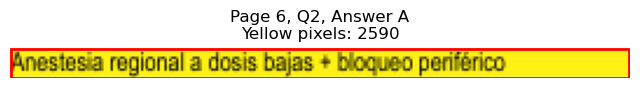

Page 6, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=291.9, y1=190.4
Page 6, Q2, B: Yellow pixels: 271
Page 6, Q2, B: Total non-white pixels: 1341
Page 6, Q2, B: Yellow percentage: 20.2%


Page 6, Q2 - C: Detected box: x0=68.8, y0=190.3, x1=229.1, y1=203.0
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 797
Page 6, Q2, C: Yellow percentage: 0.0%


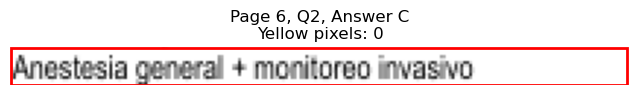

Page 6, Q2 - D: Detected box: x0=68.8, y0=202.9, x1=182.3, y1=215.6
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 584
Page 6, Q2, D: Yellow percentage: 0.0%


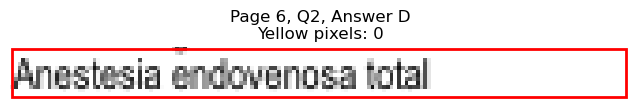


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=266.1, x1=187.7, y1=278.7
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 556
Page 6, Q3, A: Yellow percentage: 0.0%


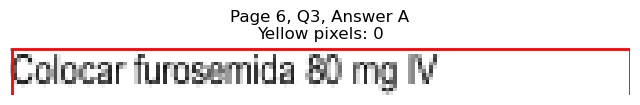

Page 6, Q3 - B: Detected box: x0=68.3, y0=278.8, x1=217.8, y1=291.5
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 777
Page 6, Q3, B: Yellow percentage: 0.0%


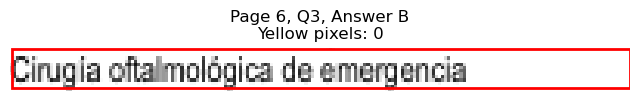

Page 6, Q3 - C: Detected box: x0=327.5, y0=266.1, x1=402.4, y1=278.7
Page 6, Q3, C: Yellow pixels: 1339
Page 6, Q3, C: Total non-white pixels: 1638
Page 6, Q3, C: Yellow percentage: 81.7%


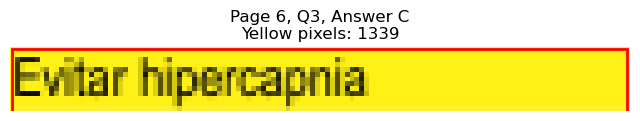

Page 6, Q3 - D: Detected box: x0=327.5, y0=278.8, x1=495.7, y1=291.5
Page 6, Q3, D: Yellow pixels: 213
Page 6, Q3, D: Total non-white pixels: 1025
Page 6, Q3, D: Yellow percentage: 20.8%


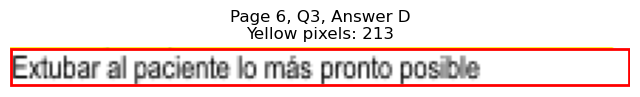


Page 6, Q3 - Selected Answer: C (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=329.2, x1=282.4, y1=341.9
Page 6, Q4, A: Yellow pixels: 1907
Page 6, Q4, A: Total non-white pixels: 2850
Page 6, Q4, A: Yellow percentage: 66.9%


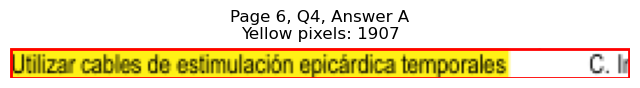

Page 6, Q4 - B: Detected box: x0=68.3, y0=341.9, x1=144.0, y1=354.6
Page 6, Q4, B: Yellow pixels: 127
Page 6, Q4, B: Total non-white pixels: 506
Page 6, Q4, B: Yellow percentage: 25.1%


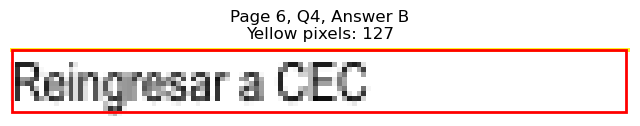

Page 6, Q4 - C: Detected box: x0=327.5, y0=329.2, x1=482.7, y1=341.9
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 802
Page 6, Q4, C: Yellow percentage: 0.0%


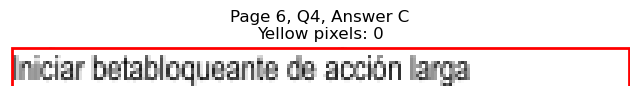

Page 6, Q4 - D: Detected box: x0=327.5, y0=341.9, x1=435.4, y1=354.6
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 581
Page 6, Q4, D: Yellow percentage: 0.0%


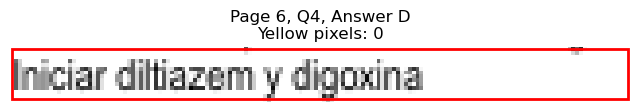


Page 6, Q4 - Selected Answer: A (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=392.3, x1=151.1, y1=405.0
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 561
Page 6, Q5, A: Yellow percentage: 0.0%


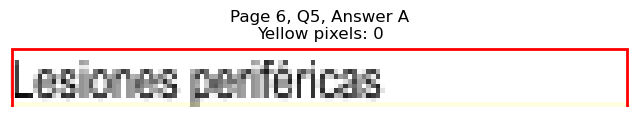

Page 6, Q5 - B: Detected box: x0=68.3, y0=404.9, x1=168.6, y1=417.6
Page 6, Q5, B: Yellow pixels: 1580
Page 6, Q5, B: Total non-white pixels: 2114
Page 6, Q5, B: Yellow percentage: 74.7%


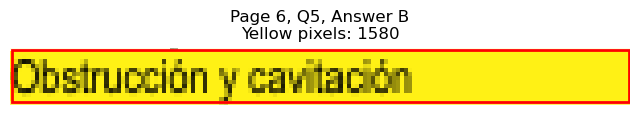

Page 6, Q5 - C: Detected box: x0=327.5, y0=392.3, x1=449.0, y1=405.0
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 575
Page 6, Q5, C: Yellow percentage: 0.0%


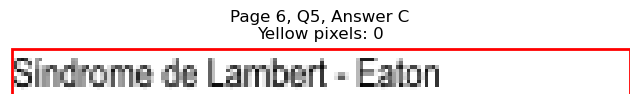

Page 6, Q5 - D: Detected box: x0=327.5, y0=404.9, x1=440.0, y1=417.6
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 592
Page 6, Q5, D: Yellow percentage: 0.0%


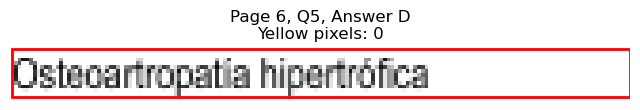


Page 6, Q5 - Selected Answer: B (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=442.8, x1=194.2, y1=455.5
Page 6, Q6, A: Yellow pixels: 1825
Page 6, Q6, A: Total non-white pixels: 2478
Page 6, Q6, A: Yellow percentage: 73.6%


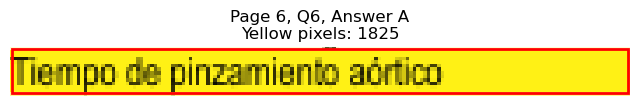

Page 6, Q6 - B: Detected box: x0=68.3, y0=455.5, x1=208.7, y1=468.1
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 695
Page 6, Q6, B: Yellow percentage: 0.0%


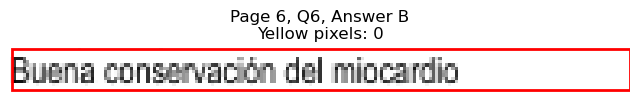

Page 6, Q6 - C: Detected box: x0=327.5, y0=442.8, x1=497.1, y1=455.5
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 889
Page 6, Q6, C: Yellow percentage: 0.0%


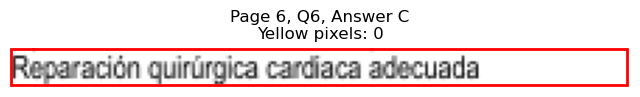

Page 6, Q6 - D: Detected box: x0=327.5, y0=455.5, x1=490.2, y1=468.1
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 817
Page 6, Q6, D: Yellow percentage: 0.0%



Page 6, Q6 - Selected Answer: A (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=506.0, x1=139.5, y1=518.6
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 326
Page 6, Q7, A: Yellow percentage: 0.0%


Page 6, Q7 - B: Detected box: x0=68.3, y0=518.6, x1=173.7, y1=531.2
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 490
Page 6, Q7, B: Yellow percentage: 0.0%


Page 6, Q7 - C: Detected box: x0=327.5, y0=506.0, x1=409.3, y1=518.6
Page 6, Q7, C: Yellow pixels: 133
Page 6, Q7, C: Total non-white pixels: 596
Page 6, Q7, C: Yellow percentage: 22.3%


Page 6, Q7 - D: Detected box: x0=327.5, y0=518.6, x1=412.9, y1=531.2
Page 6, Q7, D: Yellow pixels: 1441
Page 6, Q7, D: Total non-white pixels: 1904
Page 6, Q7, D: Yellow percentage: 75.7%



Page 6, Q7 - Selected Answer: D (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=556.5, x1=110.4, y1=569.2
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 209
Page 6, Q8, A: Yellow percentage: 0.0%


Page 6, Q8 - B: Detected box: x0=68.3, y0=569.1, x1=118.9, y1=581.8
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 234
Page 6, Q8, B: Yellow percentage: 0.0%


Page 6, Q8 - C: Detected box: x0=327.5, y0=556.5, x1=366.2, y1=569.2
Page 6, Q8, C: Yellow pixels: 90
Page 6, Q8, C: Total non-white pixels: 291
Page 6, Q8, C: Yellow percentage: 30.9%


Page 6, Q8 - D: Detected box: x0=327.5, y0=569.1, x1=373.7, y1=581.8
Page 6, Q8, D: Yellow pixels: 1067
Page 6, Q8, D: Total non-white pixels: 1261
Page 6, Q8, D: Yellow percentage: 84.6%



Page 6, Q8 - Selected Answer: D (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=606.9, x1=106.9, y1=619.6
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 198
Page 6, Q9, A: Yellow percentage: 0.0%


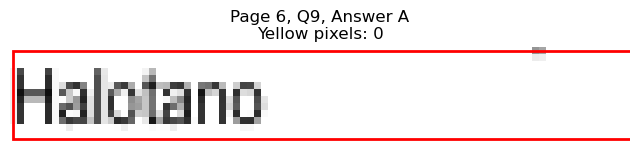

Page 6, Q9 - B: Detected box: x0=68.3, y0=619.6, x1=243.4, y1=632.3
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 884
Page 6, Q9, B: Yellow percentage: 0.0%


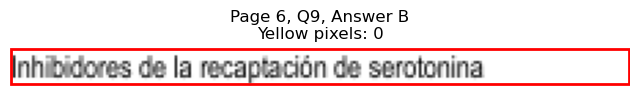

Page 6, Q9 - C: Detected box: x0=327.5, y0=606.9, x1=375.2, y1=619.6
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 248
Page 6, Q9, C: Yellow percentage: 0.0%


Page 6, Q9 - D: Detected box: x0=327.5, y0=619.6, x1=382.7, y1=632.3
Page 6, Q9, D: Yellow pixels: 1038
Page 6, Q9, D: Total non-white pixels: 1484
Page 6, Q9, D: Yellow percentage: 69.9%


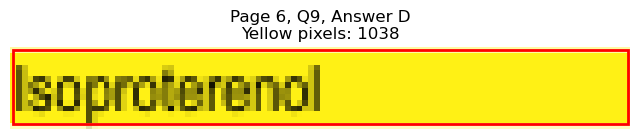


Page 6, Q9 - Selected Answer: D (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=68.3, y0=657.5, x1=161.1, y1=670.1
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 486
Page 6, Q10, A: Yellow percentage: 0.0%


Page 6, Q10 - B: Detected box: x0=68.3, y0=670.1, x1=156.0, y1=682.7
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 477
Page 6, Q10, B: Yellow percentage: 0.0%


Page 6, Q10 - C: Detected box: x0=327.5, y0=657.5, x1=446.3, y1=670.1
Page 6, Q10, C: Yellow pixels: 170
Page 6, Q10, C: Total non-white pixels: 769
Page 6, Q10, C: Yellow percentage: 22.1%


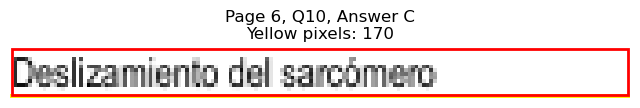

Page 6, Q10 - D: Detected box: x0=327.5, y0=670.1, x1=366.7, y1=682.7
Page 6, Q10, D: Yellow pixels: 1018
Page 6, Q10, D: Total non-white pixels: 1170
Page 6, Q10, D: Yellow percentage: 87.0%


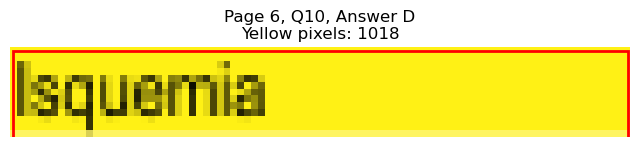


Page 6, Q10 - Selected Answer: D (based on yellow pixel count)




Page 6, Q11 - A: Detected box: x0=68.3, y0=720.6, x1=96.4, y1=733.2
Page 6, Q11, A: Yellow pixels: 0
Page 6, Q11, A: Total non-white pixels: 145
Page 6, Q11, A: Yellow percentage: 0.0%


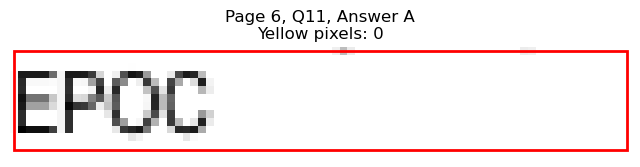

Page 6, Q11 - B: Detected box: x0=68.3, y0=733.2, x1=87.9, y1=745.8
Page 6, Q11, B: Yellow pixels: 0
Page 6, Q11, B: Total non-white pixels: 90
Page 6, Q11, B: Yellow percentage: 0.0%


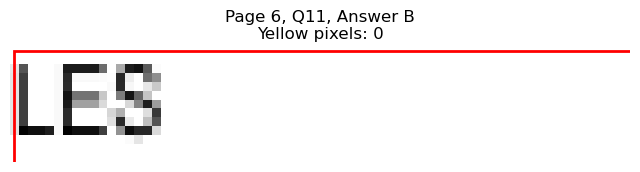

Page 6, Q11 - C: Detected box: x0=327.5, y0=720.6, x1=410.9, y1=733.2
Page 6, Q11, C: Yellow pixels: 1375
Page 6, Q11, C: Total non-white pixels: 1876
Page 6, Q11, C: Yellow percentage: 73.3%


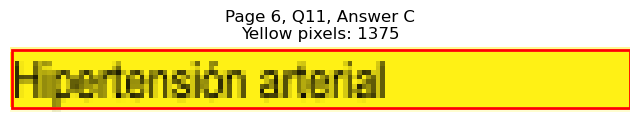

Page 6, Q11 - D: Detected box: x0=327.5, y0=455.5, x1=379.8, y1=468.1
Page 6, Q11, D: Yellow pixels: 0
Page 6, Q11, D: Total non-white pixels: 521
Page 6, Q11, D: Yellow percentage: 0.0%



Page 6, Q11 - Selected Answer: C (based on yellow pixel count)





Page 7: Found 11 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=268.4, y1=102.1
Page 7, Q1, A: Yellow pixels: 1997
Page 7, Q1, A: Total non-white pixels: 3014
Page 7, Q1, A: Yellow percentage: 66.3%


Page 7, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=158.1, y1=114.7
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 590
Page 7, Q1, B: Yellow percentage: 0.0%


Page 7, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=496.2, y1=102.1
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 839
Page 7, Q1, C: Yellow percentage: 0.0%


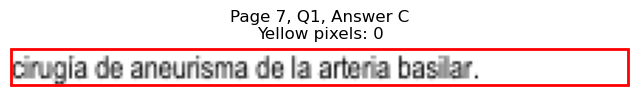

Page 7, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=433.9, y1=114.7
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 544
Page 7, Q1, D: Yellow percentage: 0.0%


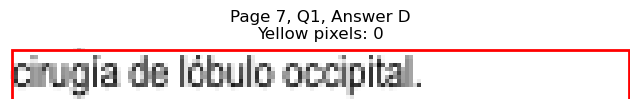


Page 7, Q1 - Selected Answer: A (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=152.5, x1=157.1, y1=165.2
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 437
Page 7, Q2, A: Yellow percentage: 0.0%


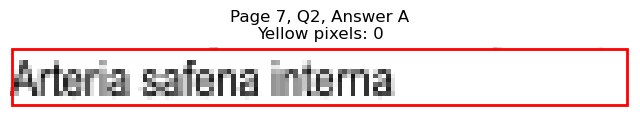

Page 7, Q2 - B: Detected box: x0=68.3, y0=165.1, x1=126.5, y1=177.8
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 295
Page 7, Q2, B: Yellow percentage: 0.0%


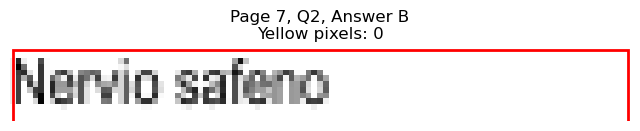

Page 7, Q2 - C: Detected box: x0=327.5, y0=152.5, x1=389.2, y1=165.2
Page 7, Q2, C: Yellow pixels: 1220
Page 7, Q2, C: Total non-white pixels: 1582
Page 7, Q2, C: Yellow percentage: 77.1%


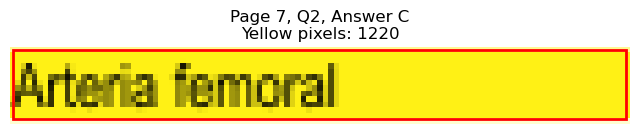

Page 7, Q2 - D: Detected box: x0=327.5, y0=165.1, x1=418.9, y1=177.8
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 589
Page 7, Q2, D: Yellow percentage: 0.0%


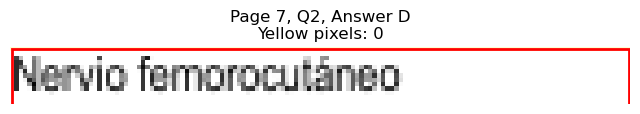


Page 7, Q2 - Selected Answer: C (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=215.7, x1=333.2, y1=228.3
Page 7, Q3, A: Yellow pixels: 2751
Page 7, Q3, A: Total non-white pixels: 4424
Page 7, Q3, A: Yellow percentage: 62.2%


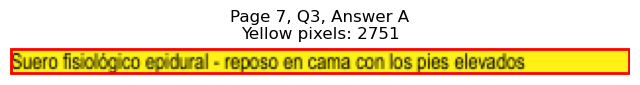

Page 7, Q3 - B: Detected box: x0=68.3, y0=228.3, x1=234.9, y1=240.9
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 1033
Page 7, Q3, B: Yellow percentage: 0.0%


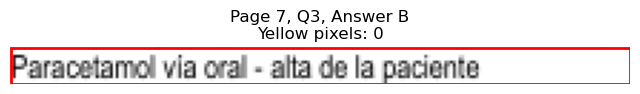

Page 7, Q3 - C: Detected box: x0=68.8, y0=240.9, x1=287.1, y1=253.5
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 1091
Page 7, Q3, C: Yellow percentage: 0.0%


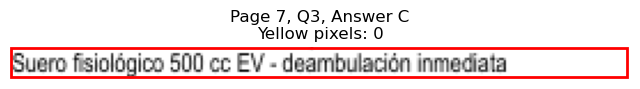

Page 7, Q3 - D: Detected box: x0=68.8, y0=253.5, x1=208.7, y1=266.1
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 689
Page 7, Q3, D: Yellow percentage: 0.0%


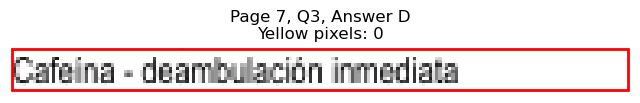


Page 7, Q3 - Selected Answer: A (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=120.5, y1=304.1
Page 7, Q4, A: Yellow pixels: 103
Page 7, Q4, A: Total non-white pixels: 338
Page 7, Q4, A: Yellow percentage: 30.5%


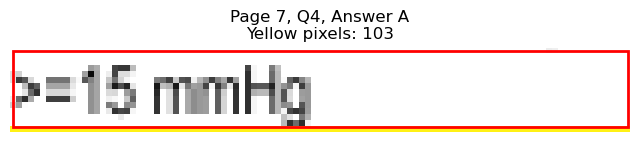

Page 7, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=115.2, y1=316.7
Page 7, Q4, B: Yellow pixels: 1116
Page 7, Q4, B: Total non-white pixels: 1274
Page 7, Q4, B: Yellow percentage: 87.6%


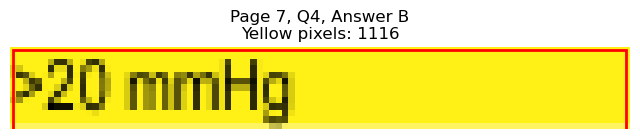

Page 7, Q4 - C: Detected box: x0=327.5, y0=291.4, x1=374.5, y1=304.1
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 215
Page 7, Q4, C: Yellow percentage: 0.0%


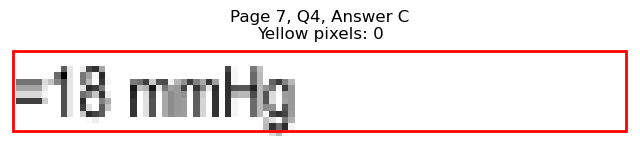

Page 7, Q4 - D: Detected box: x0=327.5, y0=304.0, x1=379.7, y1=316.7
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 233
Page 7, Q4, D: Yellow percentage: 0.0%


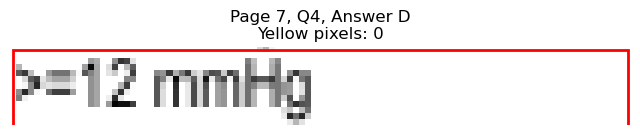


Page 7, Q4 - Selected Answer: B (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=176.8, y1=379.8
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 719
Page 7, Q5, A: Yellow percentage: 0.0%


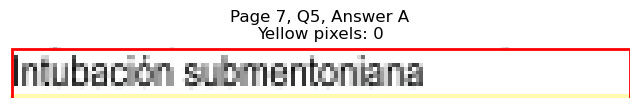

Page 7, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=131.7, y1=392.4
Page 7, Q5, B: Yellow pixels: 1105
Page 7, Q5, B: Total non-white pixels: 1596
Page 7, Q5, B: Yellow percentage: 69.2%


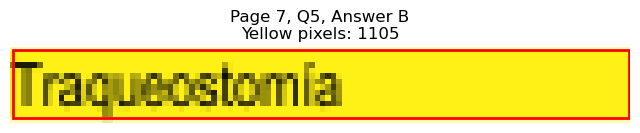

Page 7, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=455.9, y1=379.8
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 644
Page 7, Q5, C: Yellow percentage: 0.0%


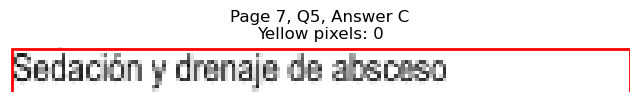

Page 7, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=492.2, y1=392.4
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 818
Page 7, Q5, D: Yellow percentage: 0.0%



Page 7, Q5 - Selected Answer: B (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=417.6, x1=170.7, y1=430.3
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 538
Page 7, Q6, A: Yellow percentage: 0.0%


Page 7, Q6 - B: Detected box: x0=68.3, y0=430.2, x1=210.9, y1=442.9
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 701
Page 7, Q6, B: Yellow percentage: 0.0%


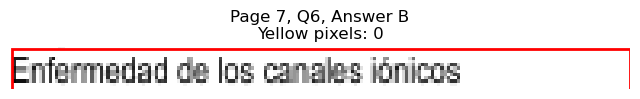

Page 7, Q6 - C: Detected box: x0=327.5, y0=417.6, x1=406.3, y1=430.3
Page 7, Q6, C: Yellow pixels: 1253
Page 7, Q6, C: Total non-white pixels: 1820
Page 7, Q6, C: Yellow percentage: 68.8%


Page 7, Q6 - D: Detected box: x0=327.5, y0=430.2, x1=376.6, y1=442.9
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 366
Page 7, Q6, D: Yellow percentage: 0.0%


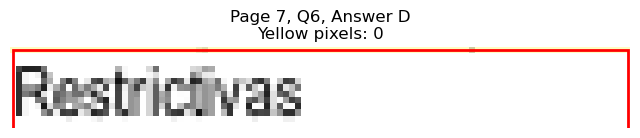


Page 7, Q6 - Selected Answer: C (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=480.8, x1=215.8, y1=493.4
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 742
Page 7, Q7, A: Yellow percentage: 0.0%


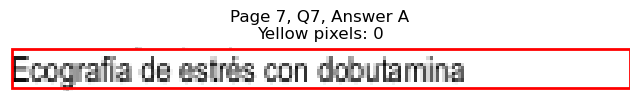

Page 7, Q7 - B: Detected box: x0=68.3, y0=493.4, x1=144.1, y1=506.0
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 360
Page 7, Q7, B: Yellow percentage: 0.0%


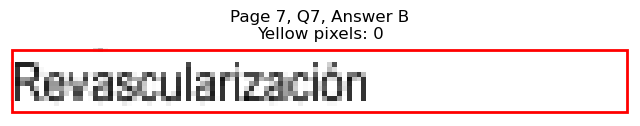

Page 7, Q7 - C: Detected box: x0=327.5, y0=480.8, x1=416.5, y1=493.4
Page 7, Q7, C: Yellow pixels: 140
Page 7, Q7, C: Total non-white pixels: 575
Page 7, Q7, C: Yellow percentage: 24.3%


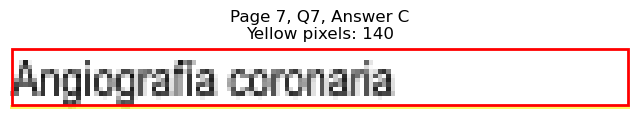

Page 7, Q7 - D: Detected box: x0=327.5, y0=493.4, x1=452.9, y1=506.0
Page 7, Q7, D: Yellow pixels: 1806
Page 7, Q7, D: Total non-white pixels: 2292
Page 7, Q7, D: Yellow percentage: 78.8%



Page 7, Q7 - Selected Answer: D (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=531.2, x1=107.9, y1=543.8
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 196
Page 7, Q8, A: Yellow percentage: 0.0%


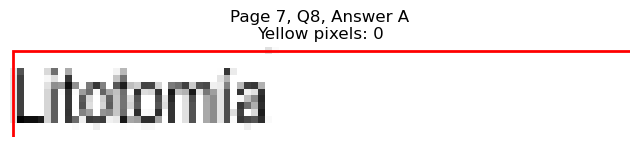

Page 7, Q8 - B: Detected box: x0=68.3, y0=543.8, x1=136.0, y1=556.4
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 319
Page 7, Q8, B: Yellow percentage: 0.0%


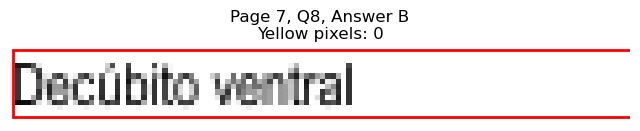

Page 7, Q8 - C: Detected box: x0=327.5, y0=531.2, x1=391.3, y1=543.8
Page 7, Q8, C: Yellow pixels: 1257
Page 7, Q8, C: Total non-white pixels: 1495
Page 7, Q8, C: Yellow percentage: 84.1%


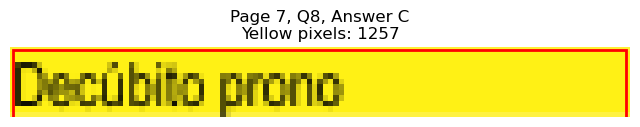

Page 7, Q8 - D: Detected box: x0=327.5, y0=543.8, x1=391.3, y1=556.4
Page 7, Q8, D: Yellow pixels: 114
Page 7, Q8, D: Total non-white pixels: 454
Page 7, Q8, D: Yellow percentage: 25.1%



Page 7, Q8 - Selected Answer: C (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=594.3, x1=265.4, y1=607.0
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 1225
Page 7, Q9, A: Yellow percentage: 0.0%


Page 7, Q9 - B: Detected box: x0=68.3, y0=606.9, x1=236.3, y1=619.6
Page 7, Q9, B: Yellow pixels: 2110
Page 7, Q9, B: Total non-white pixels: 2996
Page 7, Q9, B: Yellow percentage: 70.4%


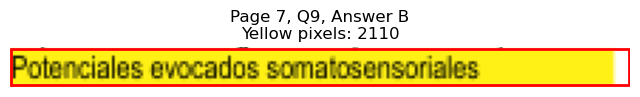

Page 7, Q9 - C: Detected box: x0=327.5, y0=594.3, x1=412.3, y1=607.0
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 410
Page 7, Q9, C: Yellow percentage: 0.0%


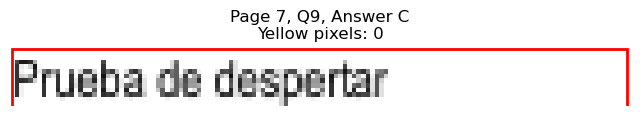

Page 7, Q9 - D: Detected box: x0=327.5, y0=606.9, x1=530.7, y1=619.6
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 1011
Page 7, Q9, D: Yellow percentage: 0.0%



Page 7, Q9 - Selected Answer: B (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=68.3, y0=644.9, x1=131.1, y1=657.5
Page 7, Q10, A: Yellow pixels: 114
Page 7, Q10, A: Total non-white pixels: 406
Page 7, Q10, A: Yellow percentage: 28.1%


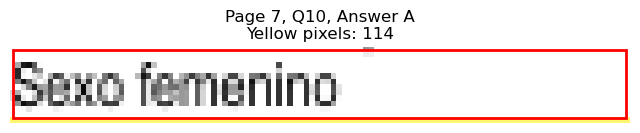

Page 7, Q10 - B: Detected box: x0=68.3, y0=657.5, x1=208.7, y1=670.1
Page 7, Q10, B: Yellow pixels: 1953
Page 7, Q10, B: Total non-white pixels: 2674
Page 7, Q10, B: Yellow percentage: 73.0%


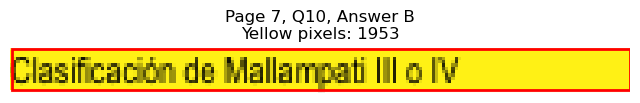

Page 7, Q10 - C: Detected box: x0=327.5, y0=644.9, x1=421.4, y1=657.5
Page 7, Q10, C: Yellow pixels: 0
Page 7, Q10, C: Total non-white pixels: 444
Page 7, Q10, C: Yellow percentage: 0.0%


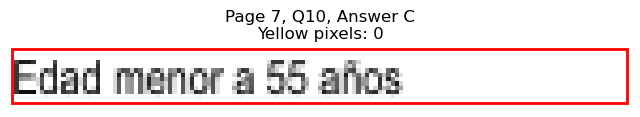

Page 7, Q10 - D: Detected box: x0=327.5, y0=657.5, x1=385.6, y1=670.1
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 302
Page 7, Q10, D: Yellow percentage: 0.0%


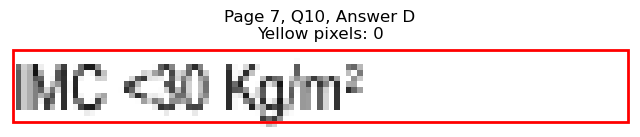


Page 7, Q10 - Selected Answer: B (based on yellow pixel count)




Page 7, Q11 - A: Detected box: x0=68.3, y0=708.0, x1=136.0, y1=720.6
Page 7, Q11, A: Yellow pixels: 118
Page 7, Q11, A: Total non-white pixels: 457
Page 7, Q11, A: Yellow percentage: 25.8%


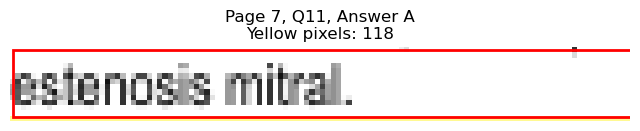

Page 7, Q11 - B: Detected box: x0=68.3, y0=720.6, x1=141.0, y1=733.2
Page 7, Q11, B: Yellow pixels: 1326
Page 7, Q11, B: Total non-white pixels: 1736
Page 7, Q11, B: Yellow percentage: 76.4%


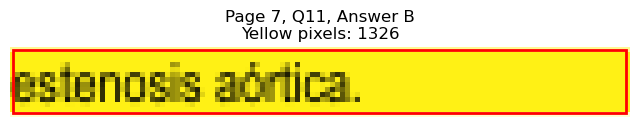

Page 7, Q11 - C: Detected box: x0=327.5, y0=708.0, x1=438.9, y1=720.6
Page 7, Q11, C: Yellow pixels: 0
Page 7, Q11, C: Total non-white pixels: 587
Page 7, Q11, C: Yellow percentage: 0.0%


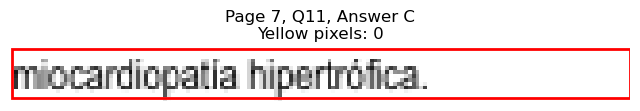

Page 7, Q11 - D: Detected box: x0=327.5, y0=720.6, x1=406.3, y1=733.2
Page 7, Q11, D: Yellow pixels: 0
Page 7, Q11, D: Total non-white pixels: 396
Page 7, Q11, D: Yellow percentage: 0.0%



Page 7, Q11 - Selected Answer: B (based on yellow pixel count)





Page 8: Found 10 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=235.5, y1=114.7
Page 8, Q1, A: Yellow pixels: 2121
Page 8, Q1, A: Total non-white pixels: 2782
Page 8, Q1, A: Yellow percentage: 76.2%


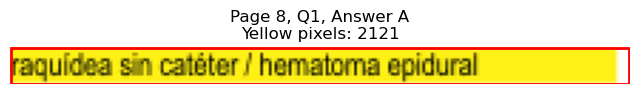

Page 8, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=225.9, y1=127.3
Page 8, Q1, B: Yellow pixels: 208
Page 8, Q1, B: Total non-white pixels: 1009
Page 8, Q1, B: Yellow percentage: 20.6%


Page 8, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=515.1, y1=114.7
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 942
Page 8, Q1, C: Yellow percentage: 0.0%


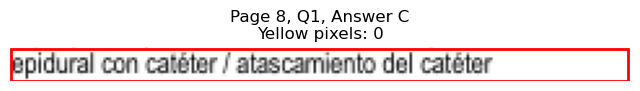

Page 8, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=499.2, y1=127.3
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 862
Page 8, Q1, D: Yellow percentage: 0.0%


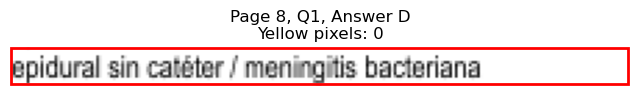


Page 8, Q1 - Selected Answer: A (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=178.1, y1=190.4
Page 8, Q2, A: Yellow pixels: 161
Page 8, Q2, A: Total non-white pixels: 709
Page 8, Q2, A: Yellow percentage: 22.7%


Page 8, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=146.5, y1=203.0
Page 8, Q2, B: Yellow pixels: 1387
Page 8, Q2, B: Total non-white pixels: 1677
Page 8, Q2, B: Yellow percentage: 82.7%


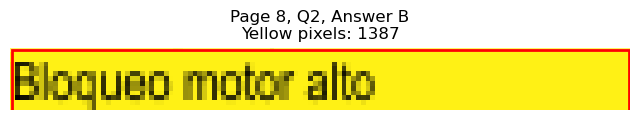

Page 8, Q2 - C: Detected box: x0=327.5, y0=177.7, x1=408.8, y1=190.4
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 427
Page 8, Q2, C: Yellow percentage: 0.0%


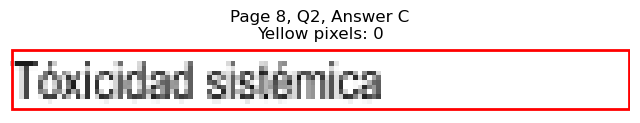

Page 8, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=410.3, y1=203.0
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 419
Page 8, Q2, D: Yellow percentage: 0.0%



Page 8, Q2 - Selected Answer: B (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=80.9, y1=253.5
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 46
Page 8, Q3, A: Yellow percentage: 0.0%


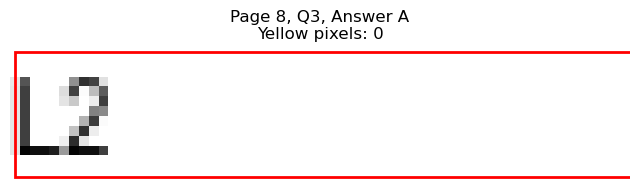

Page 8, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=81.4, y1=266.1
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 51
Page 8, Q3, B: Yellow percentage: 0.0%


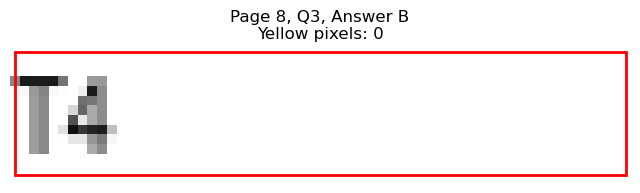

Page 8, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=340.6, y1=253.5
Page 8, Q3, C: Yellow pixels: 64
Page 8, Q3, C: Total non-white pixels: 122
Page 8, Q3, C: Yellow percentage: 52.5%


Page 8, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=345.7, y1=266.1
Page 8, Q3, D: Yellow pixels: 836
Page 8, Q3, D: Total non-white pixels: 966
Page 8, Q3, D: Yellow percentage: 86.5%


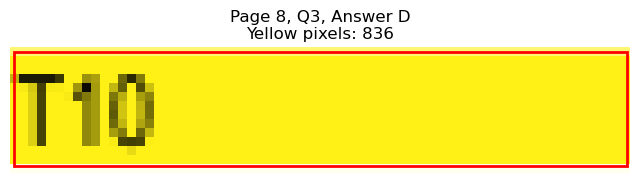


Page 8, Q3 - Selected Answer: D (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=94.3, y1=304.1
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 169
Page 8, Q4, A: Yellow percentage: 0.0%


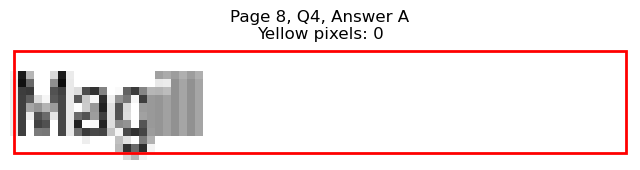

Page 8, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=118.5, y1=316.7
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 268
Page 8, Q4, B: Yellow percentage: 0.0%


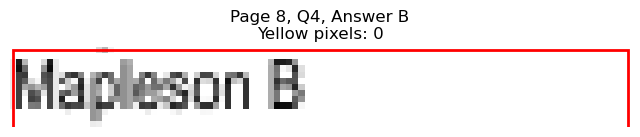

Page 8, Q4 - C: Detected box: x0=327.5, y0=291.4, x1=348.1, y1=304.1
Page 8, Q4, C: Yellow pixels: 864
Page 8, Q4, C: Total non-white pixels: 1008
Page 8, Q4, C: Yellow percentage: 85.7%


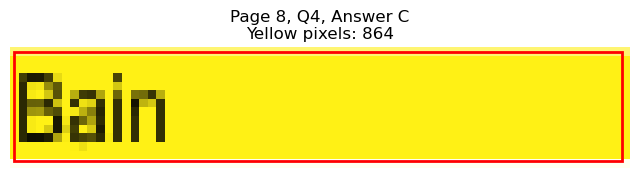

Page 8, Q4 - D: Detected box: x0=327.5, y0=304.0, x1=392.2, y1=316.7
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 416
Page 8, Q4, D: Yellow percentage: 0.0%


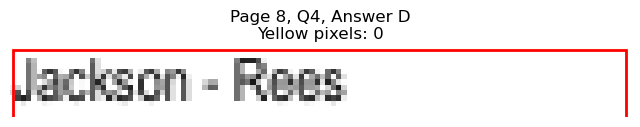


Page 8, Q4 - Selected Answer: C (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=106.9, y1=379.8
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 290
Page 8, Q5, A: Yellow percentage: 0.0%


Page 8, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=149.1, y1=392.4
Page 8, Q5, B: Yellow pixels: 1250
Page 8, Q5, B: Total non-white pixels: 1848
Page 8, Q5, B: Yellow percentage: 67.6%


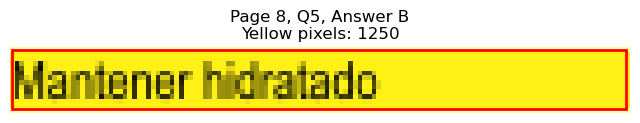

Page 8, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=426.9, y1=379.8
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 506
Page 8, Q5, C: Yellow percentage: 0.0%


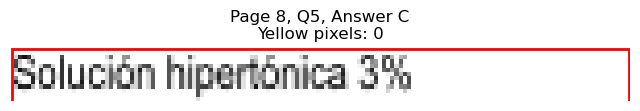

Page 8, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=407.5, y1=392.4
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 413
Page 8, Q5, D: Yellow percentage: 0.0%


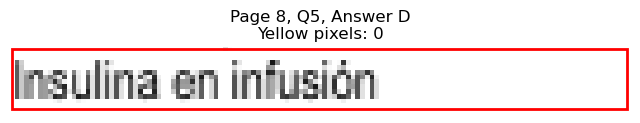


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=417.6, x1=327.3, y1=430.3
Page 8, Q6, A: Yellow pixels: 2695
Page 8, Q6, A: Total non-white pixels: 4340
Page 8, Q6, A: Yellow percentage: 62.1%


Page 8, Q6 - B: Detected box: x0=68.3, y0=430.2, x1=201.3, y1=442.9
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 866
Page 8, Q6, B: Yellow percentage: 0.0%


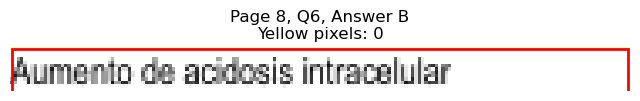

Page 8, Q6 - C: Detected box: x0=68.8, y0=442.8, x1=211.2, y1=455.5
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 690
Page 8, Q6, C: Yellow percentage: 0.0%


Page 8, Q6 - D: Detected box: x0=68.8, y0=455.5, x1=315.6, y1=468.1
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 1236
Page 8, Q6, D: Yellow percentage: 0.0%


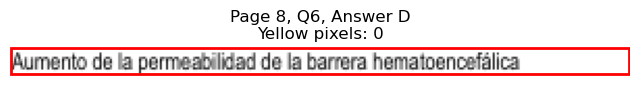


Page 8, Q6 - Selected Answer: A (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=506.0, x1=165.6, y1=518.6
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 461
Page 8, Q7, A: Yellow percentage: 0.0%


Page 8, Q7 - B: Detected box: x0=68.3, y0=518.6, x1=206.2, y1=531.2
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 705
Page 8, Q7, B: Yellow percentage: 0.0%


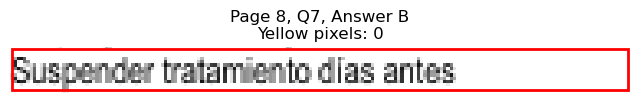

Page 8, Q7 - C: Detected box: x0=327.5, y0=506.0, x1=509.7, y1=518.6
Page 8, Q7, C: Yellow pixels: 2102
Page 8, Q7, C: Total non-white pixels: 2995
Page 8, Q7, C: Yellow percentage: 70.2%


Page 8, Q7 - D: Detected box: x0=327.5, y0=518.6, x1=424.4, y1=531.2
Page 8, Q7, D: Yellow pixels: 148
Page 8, Q7, D: Total non-white pixels: 627
Page 8, Q7, D: Yellow percentage: 23.6%


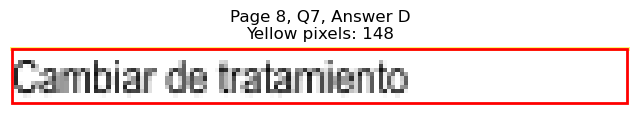


Page 8, Q7 - Selected Answer: C (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=569.1, x1=114.4, y1=581.8
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 247
Page 8, Q8, A: Yellow percentage: 0.0%


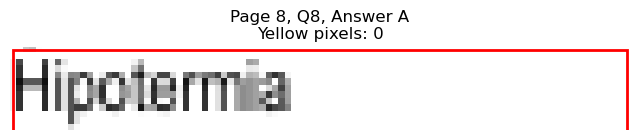

Page 8, Q8 - B: Detected box: x0=68.3, y0=581.7, x1=158.1, y1=594.4
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 456
Page 8, Q8, B: Yellow percentage: 0.0%


Page 8, Q8 - C: Detected box: x0=327.5, y0=569.1, x1=376.6, y1=581.8
Page 8, Q8, C: Yellow pixels: 1081
Page 8, Q8, C: Total non-white pixels: 1300
Page 8, Q8, C: Yellow percentage: 83.2%


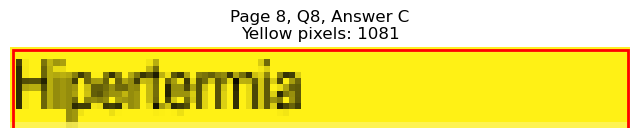

Page 8, Q8 - D: Detected box: x0=327.5, y0=581.7, x1=410.3, y1=594.4
Page 8, Q8, D: Yellow pixels: 134
Page 8, Q8, D: Total non-white pixels: 571
Page 8, Q8, D: Yellow percentage: 23.5%



Page 8, Q8 - Selected Answer: C (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=644.9, x1=131.7, y1=657.5
Page 8, Q9, A: Yellow pixels: 114
Page 8, Q9, A: Total non-white pixels: 443
Page 8, Q9, A: Yellow percentage: 25.7%


Page 8, Q9 - B: Detected box: x0=68.3, y0=657.5, x1=201.8, y1=670.1
Page 8, Q9, B: Yellow pixels: 1865
Page 8, Q9, B: Total non-white pixels: 2576
Page 8, Q9, B: Yellow percentage: 72.4%


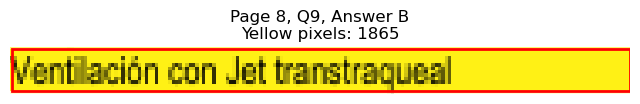

Page 8, Q9 - C: Detected box: x0=68.8, y0=670.2, x1=157.2, y1=682.8
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 575
Page 8, Q9, C: Yellow percentage: 0.0%


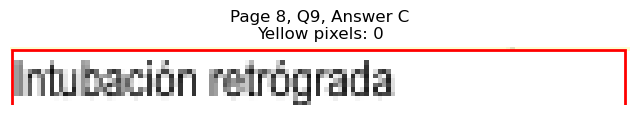

Page 8, Q9 - D: Detected box: x0=327.5, y0=644.9, x1=371.8, y1=657.5
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 433
Page 8, Q9, D: Yellow percentage: 0.0%


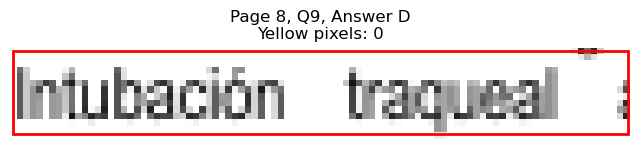


Page 8, Q9 - Selected Answer: B (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=68.3, y0=720.6, x1=300.0, y1=733.2
Page 8, Q10, A: Yellow pixels: 2752
Page 8, Q10, A: Total non-white pixels: 3962
Page 8, Q10, A: Yellow percentage: 69.5%


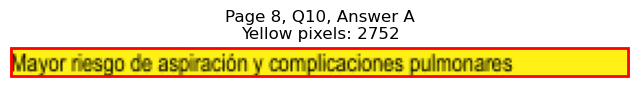

Page 8, Q10 - B: Detected box: x0=68.3, y0=733.2, x1=299.1, y1=745.8
Page 8, Q10, B: Yellow pixels: 0
Page 8, Q10, B: Total non-white pixels: 1457
Page 8, Q10, B: Yellow percentage: 0.0%


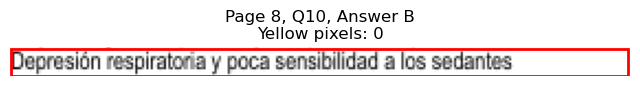

Page 8, Q10 - C: Detected box: x0=68.8, y0=745.9, x1=277.4, y1=758.6
Page 8, Q10, C: Yellow pixels: 0
Page 8, Q10, C: Total non-white pixels: 1011
Page 8, Q10, C: Yellow percentage: 0.0%


Page 8, Q10 - D: Detected box: x0=68.8, y0=758.5, x1=323.6, y1=771.2
Page 8, Q10, D: Yellow pixels: 0
Page 8, Q10, D: Total non-white pixels: 1271
Page 8, Q10, D: Yellow percentage: 0.0%


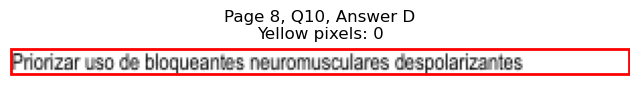


Page 8, Q10 - Selected Answer: A (based on yellow pixel count)





Page 9: Found 11 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=216.3, y1=102.1
Page 9, Q1, A: Yellow pixels: 1984
Page 9, Q1, A: Total non-white pixels: 2786
Page 9, Q1, A: Yellow percentage: 71.2%


Page 9, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=165.1, y1=114.7
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 630
Page 9, Q1, B: Yellow percentage: 0.0%


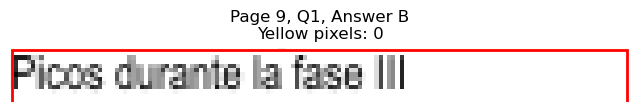

Page 9, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=433.9, y1=102.1
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 531
Page 9, Q1, C: Yellow percentage: 0.0%


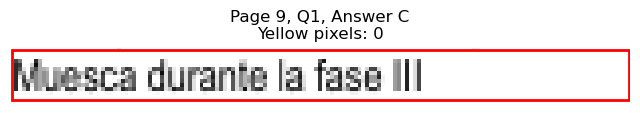

Page 9, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=427.9, y1=114.7
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 496
Page 9, Q1, D: Yellow percentage: 0.0%



Page 9, Q1 - Selected Answer: A (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=139.9, x1=122.4, y1=152.6
Page 9, Q2, A: Yellow pixels: 1155
Page 9, Q2, A: Total non-white pixels: 1470
Page 9, Q2, A: Yellow percentage: 78.6%


Page 9, Q2 - B: Detected box: x0=68.3, y0=152.5, x1=126.5, y1=165.2
Page 9, Q2, B: Yellow pixels: 109
Page 9, Q2, B: Total non-white pixels: 409
Page 9, Q2, B: Yellow percentage: 26.7%


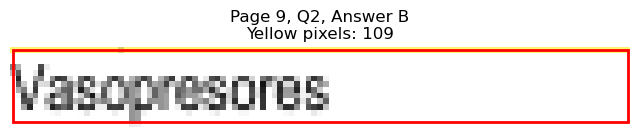

Page 9, Q2 - C: Detected box: x0=327.5, y0=139.9, x1=345.6, y1=152.6
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 103
Page 9, Q2, C: Yellow percentage: 0.0%


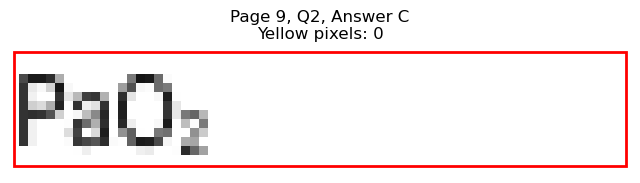

Page 9, Q2 - D: Detected box: x0=327.5, y0=152.5, x1=418.4, y1=165.2
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 467
Page 9, Q2, D: Yellow percentage: 0.0%


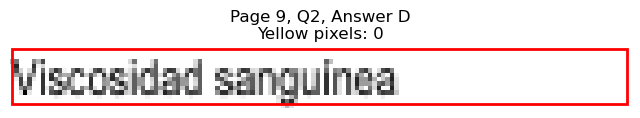


Page 9, Q2 - Selected Answer: A (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=202.9, x1=79.3, y1=215.6
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 36
Page 9, Q3, A: Yellow percentage: 0.0%


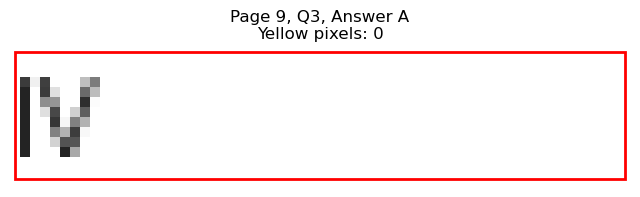

Page 9, Q3 - B: Detected box: x0=68.3, y0=215.7, x1=76.8, y1=228.3
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 28
Page 9, Q3, B: Yellow percentage: 0.0%


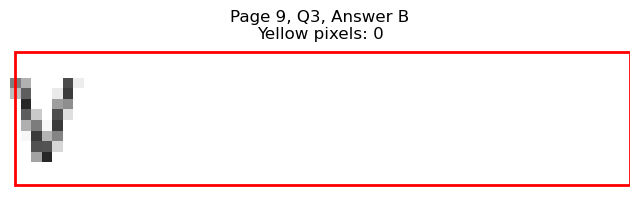

Page 9, Q3 - C: Detected box: x0=315.4, y0=202.9, x1=324.4, y1=215.6
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 76
Page 9, Q3, C: Yellow percentage: 0.0%


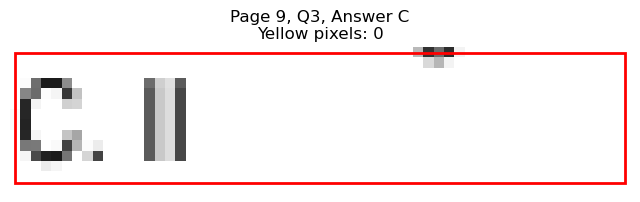

Page 9, Q3 - D: Detected box: x0=327.5, y0=215.7, x1=337.6, y1=228.3
Page 9, Q3, D: Yellow pixels: 692
Page 9, Q3, D: Total non-white pixels: 854
Page 9, Q3, D: Yellow percentage: 81.0%


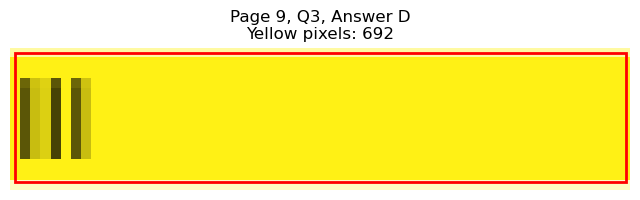


Page 9, Q3 - Selected Answer: D (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=253.5, x1=165.6, y1=266.1
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 460
Page 9, Q4, A: Yellow percentage: 0.0%


Page 9, Q4 - B: Detected box: x0=68.3, y0=266.1, x1=108.0, y1=278.7
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 206
Page 9, Q4, B: Yellow percentage: 0.0%


Page 9, Q4 - C: Detected box: x0=327.5, y0=253.5, x1=351.7, y1=266.1
Page 9, Q4, C: Yellow pixels: 75
Page 9, Q4, C: Total non-white pixels: 198
Page 9, Q4, C: Yellow percentage: 37.9%


Page 9, Q4 - D: Detected box: x0=327.5, y0=266.1, x1=390.2, y1=278.7
Page 9, Q4, D: Yellow pixels: 1214
Page 9, Q4, D: Total non-white pixels: 1482
Page 9, Q4, D: Yellow percentage: 81.9%



Page 9, Q4 - Selected Answer: D (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=329.2, x1=211.2, y1=341.9
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 743
Page 9, Q5, A: Yellow percentage: 0.0%


Page 9, Q5 - B: Detected box: x0=68.3, y0=341.9, x1=159.1, y1=354.6
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 458
Page 9, Q5, B: Yellow percentage: 0.0%


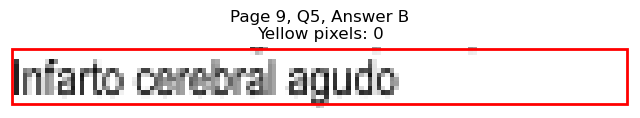

Page 9, Q5 - C: Detected box: x0=327.5, y0=329.2, x1=370.6, y1=341.9
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 213
Page 9, Q5, C: Yellow percentage: 0.0%


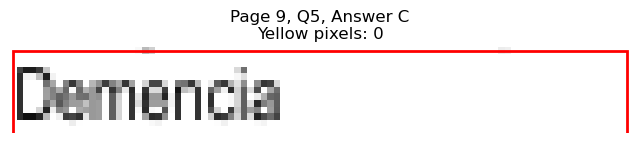

Page 9, Q5 - D: Detected box: x0=327.5, y0=341.9, x1=423.3, y1=354.6
Page 9, Q5, D: Yellow pixels: 1500
Page 9, Q5, D: Total non-white pixels: 2058
Page 9, Q5, D: Yellow percentage: 72.9%


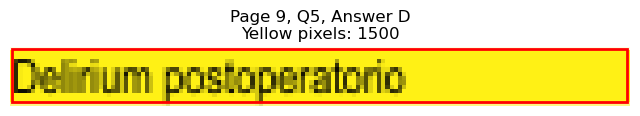


Page 9, Q5 - Selected Answer: D (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=379.7, x1=114.5, y1=392.4
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 241
Page 9, Q6, A: Yellow percentage: 0.0%


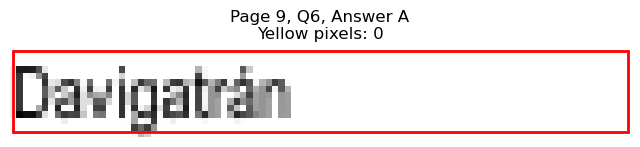

Page 9, Q6 - B: Detected box: x0=68.3, y0=392.3, x1=130.5, y1=405.0
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 323
Page 9, Q6, B: Yellow percentage: 0.0%


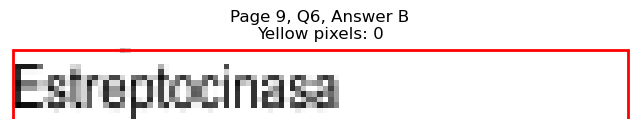

Page 9, Q6 - C: Detected box: x0=327.5, y0=379.7, x1=367.1, y1=392.4
Page 9, Q6, C: Yellow pixels: 921
Page 9, Q6, C: Total non-white pixels: 1274
Page 9, Q6, C: Yellow percentage: 72.3%


Page 9, Q6 - D: Detected box: x0=327.5, y0=392.3, x1=380.7, y1=405.0
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 378
Page 9, Q6, D: Yellow percentage: 0.0%


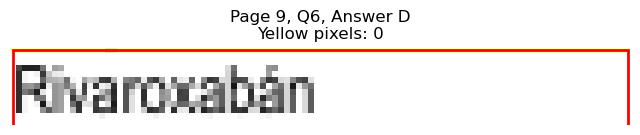


Page 9, Q6 - Selected Answer: C (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=442.8, x1=136.6, y1=455.5
Page 9, Q7, A: Yellow pixels: 119
Page 9, Q7, A: Total non-white pixels: 487
Page 9, Q7, A: Yellow percentage: 24.4%


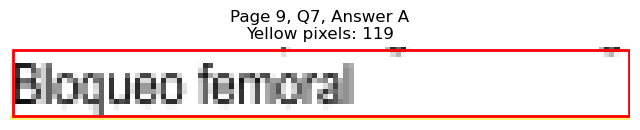

Page 9, Q7 - B: Detected box: x0=68.3, y0=455.5, x1=195.7, y1=468.1
Page 9, Q7, B: Yellow pixels: 1831
Page 9, Q7, B: Total non-white pixels: 2492
Page 9, Q7, B: Yellow percentage: 73.5%


Page 9, Q7 - C: Detected box: x0=327.5, y0=442.8, x1=524.4, y1=455.5
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 978
Page 9, Q7, C: Yellow percentage: 0.0%


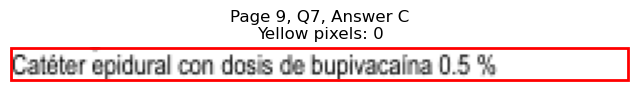

Page 9, Q7 - D: Detected box: x0=327.5, y0=455.5, x1=437.9, y1=468.1
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 572
Page 9, Q7, D: Yellow percentage: 0.0%


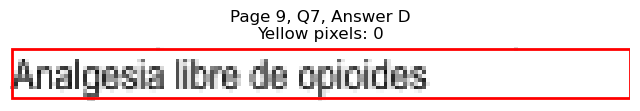


Page 9, Q7 - Selected Answer: B (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=493.4, x1=148.6, y1=506.0
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 413
Page 9, Q8, A: Yellow percentage: 0.0%


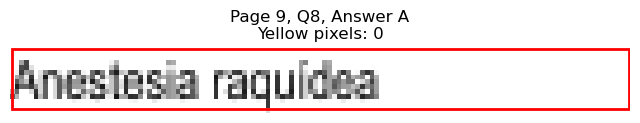

Page 9, Q8 - B: Detected box: x0=68.3, y0=506.0, x1=153.0, y1=518.6
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 411
Page 9, Q8, B: Yellow percentage: 0.0%


Page 9, Q8 - C: Detected box: x0=327.5, y0=493.4, x1=412.9, y1=506.0
Page 9, Q8, C: Yellow pixels: 1433
Page 9, Q8, C: Total non-white pixels: 1768
Page 9, Q8, C: Yellow percentage: 81.1%


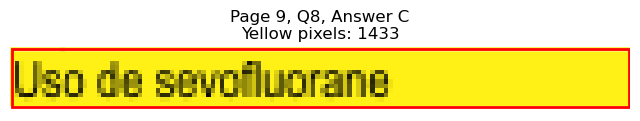

Page 9, Q8 - D: Detected box: x0=327.5, y0=506.0, x1=434.5, y1=518.6
Page 9, Q8, D: Yellow pixels: 158
Page 9, Q8, D: Total non-white pixels: 699
Page 9, Q8, D: Yellow percentage: 22.6%


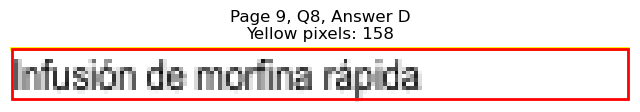


Page 9, Q8 - Selected Answer: C (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=556.5, x1=180.1, y1=569.2
Page 9, Q9, A: Yellow pixels: 163
Page 9, Q9, A: Total non-white pixels: 724
Page 9, Q9, A: Yellow percentage: 22.5%


Page 9, Q9 - B: Detected box: x0=68.3, y0=569.1, x1=251.4, y1=581.8
Page 9, Q9, B: Yellow pixels: 2029
Page 9, Q9, B: Total non-white pixels: 2782
Page 9, Q9, B: Yellow percentage: 72.9%


Page 9, Q9 - C: Detected box: x0=327.5, y0=556.5, x1=426.8, y1=569.2
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 497
Page 9, Q9, C: Yellow percentage: 0.0%


Page 9, Q9 - D: Detected box: x0=327.5, y0=569.1, x1=362.6, y1=581.8
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 335
Page 9, Q9, D: Yellow percentage: 0.0%



Page 9, Q9 - Selected Answer: B (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=68.3, y0=606.9, x1=227.3, y1=619.6
Page 9, Q10, A: Yellow pixels: 0
Page 9, Q10, A: Total non-white pixels: 790
Page 9, Q10, A: Yellow percentage: 0.0%


Page 9, Q10 - B: Detected box: x0=68.3, y0=619.6, x1=211.2, y1=632.3
Page 9, Q10, B: Yellow pixels: 1796
Page 9, Q10, B: Total non-white pixels: 2716
Page 9, Q10, B: Yellow percentage: 66.1%


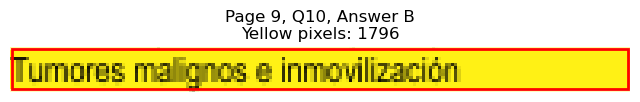

Page 9, Q10 - C: Detected box: x0=327.5, y0=606.9, x1=482.6, y1=619.6
Page 9, Q10, C: Yellow pixels: 0
Page 9, Q10, C: Total non-white pixels: 772
Page 9, Q10, C: Yellow percentage: 0.0%


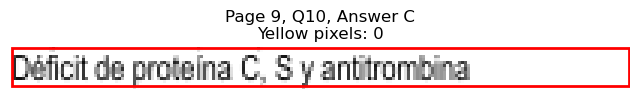

Page 9, Q10 - D: Detected box: x0=327.5, y0=619.6, x1=500.3, y1=632.3
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 919
Page 9, Q10, D: Yellow percentage: 0.0%


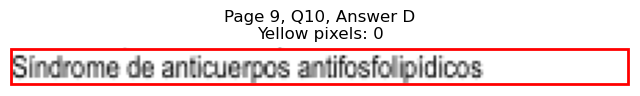


Page 9, Q10 - Selected Answer: B (based on yellow pixel count)




Page 9, Q11 - A: Detected box: x0=68.3, y0=657.5, x1=93.9, y1=670.1
Page 9, Q11, A: Yellow pixels: 76
Page 9, Q11, A: Total non-white pixels: 182
Page 9, Q11, A: Yellow percentage: 41.8%


Page 9, Q11 - B: Detected box: x0=68.3, y0=670.1, x1=93.9, y1=682.7
Page 9, Q11, B: Yellow pixels: 900
Page 9, Q11, B: Total non-white pixels: 988
Page 9, Q11, B: Yellow percentage: 91.1%


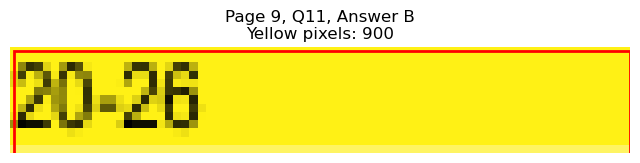

Page 9, Q11 - C: Detected box: x0=327.5, y0=657.5, x1=353.1, y1=670.1
Page 9, Q11, C: Yellow pixels: 0
Page 9, Q11, C: Total non-white pixels: 118
Page 9, Q11, C: Yellow percentage: 0.0%


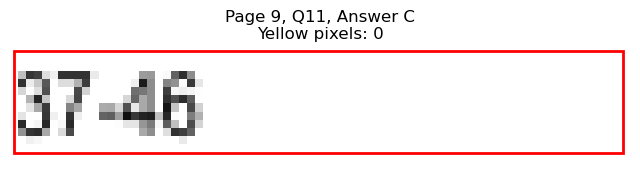

Page 9, Q11 - D: Detected box: x0=327.5, y0=670.1, x1=353.1, y1=682.7
Page 9, Q11, D: Yellow pixels: 0
Page 9, Q11, D: Total non-white pixels: 122
Page 9, Q11, D: Yellow percentage: 0.0%


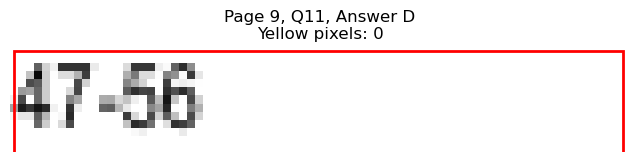


Page 9, Q11 - Selected Answer: B (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Varón obeso de 50 años, sometido a restitución...
1   ¿Cuál es el tratamiento para la fibrilación ve...
2   En la clasificación de Hunt-Hess; el grado I c...
3   ¿Cuál es el factor que contribuye a la prolong...
4   En el monitoreo de presión arterial invasiva e...
..                                                ...
95  Varón de 65 años, antecedente de carcinoma de ...
96  ¿Cuál es la medida anestésica a seguir para la...
97  Varón de 48 años sometido a cirugía de meningi...
98  ¿Cuáles son los riesgos moderados del estado d...
99  En anestesia general y/o hipnosis profunda. ¿C...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0          Bloqueo neuromuscular residual   
1               Administración de volumen   
2      obnubilación o déficit focal leve.   
3                  Alcalosis respiratoria   
4                       Estenosis aórtica   
..                                    ...   
95                        Bloqueo femoral   
96                     Anestesia raquídea   
97             Vasopresores e inotrópicos   
98  Trombocitopenia inducida por heparina   
99                                  13-19   

                                          option_B  \
0                                Paro respiratorio   
1                                         Sedación   
2                           estupor y hemiparesia.   
3            Antagonistas de los canales de calcio   
4                            Insuficiencia aórtica   
..                                             ...   
95                   AINES, paracetamol y opioides   
96                            Infusiones EV lentas   
97  Aspirar aire intravascular de arteria pulmonar   
98               Tumores malignos e inmovilización   
99                                           20-26   

                                           option_C  \
0                       Edema en vías respiratorias   
1                                     Cardioversión   
2                cefalea moderada, rigidez de nuca.   
3                                       Hipertermia   
4                       Miocardiopatía hipertrófica   
..                                              ...   
95  Catéter epidural con dosis de bupivacaína 0.5 %   
96                              Uso de sevofluorane   
97                           Compresiones torácicas   
98          Déficit de proteína C, S y antitrombina   
99                                            37-46   

                                            option_D  
0                                      Larigoespasmo  
1                                 Uso de agonista ß2  
2            cefalea mínima, ligera rigidez de nuca.  
3                   Antiinflamatorios no esteroideos  
4   Insuficiencia sistólica del ventrículo izquierdo  
..                                               ...  
95                       Analgesia libre de opioides  
96                        Infusión de morfina rápida  
97                                  Bajar fiO2 a 50%  
98        Síndrome de anticuerpos antifosfolipídicos  
99                                             47-56  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               A
1               C
2               D
3               B
4               B
..            ...
95              B
96              C
97              B
98              B
99              B

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   Varón obeso de 50 años, sometido a restitución...   
1   ¿Cuál es el tratamiento para la fibrilación ve...   
2   En la clasificación de Hunt-Hess; el grado I c...   
3   ¿Cuál es el factor que contribuye a la prolong...   
4   En el monitoreo de presión arterial invasiva e...   
..                                                ...   
95  Varón de 65 años, antecedente de carcinoma de ...   
96  ¿Cuál es la medida anestésica a seguir para la...   
97  Varón de 48 años sometido a cirugía de meningi...   
98  ¿Cuáles son los riesgos moderados del estado d...   
99  En anestesia general y/o hipnosis profunda. ¿C...   

                                 option_A  \
0          Bloqueo neuromuscular residual   
1               Administración de volumen   
2      obnubilación o déficit focal leve.   
3                  Alcalosis respiratoria   
4                       Estenosis aórtica   
..                                    ...   
95                        Bloqueo femoral   
96                     Anestesia raquídea   
97             Vasopresores e inotrópicos   
98  Trombocitopenia inducida por heparina   
99                                  13-19   

                                          option_B  \
0                                Paro respiratorio   
1                                         Sedación   
2                           estupor y hemiparesia.   
3            Antagonistas de los canales de calcio   
4                            Insuficiencia aórtica   
..                                             ...   
95                   AINES, paracetamol y opioides   
96                            Infusiones EV lentas   
97  Aspirar aire intravascular de arteria pulmonar   
98               Tumores malignos e inmovilización   
99                                           20-26   

                                           option_C  \
0                       Edema en vías respiratorias   
1                                     Cardioversión   
2                cefalea moderada, rigidez de nuca.   
3                                       Hipertermia   
4                       Miocardiopatía hipertrófica   
..                                              ...   
95  Catéter epidural con dosis de bupivacaína 0.5 %   
96                              Uso de sevofluorane   
97                           Compresiones torácicas   
98          Déficit de proteína C, S y antitrombina   
99                                            37-46   

                                            option_D correct_answer  
0                                      Larigoespasmo              A  
1                                 Uso de agonista ß2              C  
2            cefalea mínima, ligera rigidez de nuca.              D  
3                   Antiinflamatorios no esteroideos              B  
4   Insuficiencia sistólica del ventrículo izquierdo              B  
..                                               ...            ...  
95                       Analgesia libre de opioides              B  
96                        Infusión de morfina rápida              C  
97                                  Bajar fiO2 a 50%              B  
98        Síndrome de anticuerpos antifosfolipídicos              B  
99                                             47-56              B  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2023/ANESTESIOLOGIA.csv
